# Parafac on covid data

In [1]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorly as tl
import torch
import pickle
from tensorly.decomposition import parafac
import tlviz
import pathintegrate
from evaluation_metrics import degeneracy_score_adapted, df_rank_evaluation
from split_half_pathway_fun import split_half, cal_fms, plt_fms
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from pathway_feature_selection import bootstrap_feature_select_pr1, feature_select_bs_ci, significant_pathways, harmonic_pvalue,combined_pseudoz, significant_pseudoz, plot_zscore_distribution

# Load multi-omics datasets and metadata
The dataset we will be working with is from Su et al. "Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19".


* Plasma metabolomics (Metabolon UHPLC-MS/MS)
* Proteomics (Olink) datasets

with matched samples, of which 45 samples had ‘mild’ COVID (WHO status 1-2), and 82 had ‘moderate-severe’ COVID19 (WHO status 3-7), totalling 127 samples

Su Y, Chen D, Yuan D, Lausted C, Choi J, Dai CL, et al. Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19. Cell. 2020;183: 1479-1495.e20. [DOI](doi:10.1016/j.cell.2020.10.037)

## Identifier harmonisation

*   Feature IDs have been converted to ChEBI for metabolites and UniProt for proteins
*   sspa package provides metabolite ID conversion utility
* IDs must match those of the pathway database
  * Reactome uses ChEBI, UniProt, and ENSEMBL
  * KEGG uses KEGG compound and KEGG gene

## Data pre-treatment
* Outlying samples should be removed
* Missing data should be imputed
* Features should be roughly normally distributed
* Features *do not need* to be scaled, this is applied internally in the model using StandardScaler (mean = 0, SD =1)


In [2]:
metab = pathintegrate.load_example_data('metabolomics')
prot = pathintegrate.load_example_data('proteomics')

The proteomics data contains the metadata column

In [3]:
prot.head()

O00182    O00220    O00253    O14763     O14836    O43915  \
sample_id                                                                   
INCOV092-BL  10.499046  4.108639  6.260154  6.722554  10.504367  8.545390   
INCOV107-BL   9.974258  3.518560  4.698671  5.985321   9.580609  8.099680   
INCOV020-BL  11.030835  5.251186  6.845172  9.054961  11.023916  7.416310   
INCOV035-BL  10.784361  4.869835  5.551323  7.855721  10.356665  7.401949   
INCOV122-BL  10.117736  3.378996  4.411282  5.230120   9.533394  7.851850   

                O94907     P00797     P01127     P01241  ...    Q9UKL0  \
sample_id                                                ...             
INCOV092-BL  10.724486   8.664588  11.701879   8.966646  ...  3.074093   
INCOV107-BL  11.021719   8.052122  12.064962   5.527914  ...  3.072335   
INCOV020-BL   9.568452  10.709513   8.344538  10.215193  ...  3.455134   
INCOV035-BL   9.968144   8.954985  10.741812  10.864942  ...  2.951877   
INCOV122-BL  11.461373   6.477619  12.242743   4.508236  ...  2.594084   

               Q9ULX7    Q9UNK0    Q9Y478    Q9Y4K4    Q9Y5A7    Q9Y5L3  \
sample_id                                                                 
INCOV092-BL  2.639784  5.146036  2.937521  8.433509  3.274849  2.070798   
INCOV107-BL  2.361624  6.274084  3.868208  8.934732  4.995750  1.731189   
INCOV020-BL  1.290294  2.154327  2.000634  4.544658  0.850766  2.234723   
INCOV035-BL  2.613248  3.618144  2.834577  6.816611  1.666262  1.785225   
INCOV122-BL  2.140240  5.903346  4.021954  8.946893  4.720346  1.060657   

               Q9Y5V3    Q9Y653   Group  
sample_id                                
INCOV092-BL  1.003806  3.503626    Mild  
INCOV107-BL  1.089978  4.399312    Mild  
INCOV020-BL  0.524290  4.840999  Severe  
INCOV035-BL  0.164508  2.451285  Severe  
INCOV122-BL  0.972700  1.404552    Mild  

[5 rows x 456 columns]

In [4]:
prot_conversion_table = pd.read_csv("/Users/yalilyu/Desktop/Covid/proteomics_metadata.csv",dtype=str)
prot_conversion_table

Unnamed: 0        name panel uniprot  gene_name  \
0             0  CAM_O00533   CAM  O00533       CHL1   
1             1  CAM_O14786   CAM  O14786       NRP1   
2             2  CAM_O15031   CAM  O15031     PLXNB2   
3             3  CAM_O75015   CAM  O75015     FCGR3B   
4             4  CAM_O75023   CAM  O75023     LILRB5   
...         ...         ...   ...     ...        ...   
1284       1284  IMO_Q9BZW8   IMO  Q9BZW8      CD244   
1285       1285  IMO_Q9NP84   IMO  Q9NP84  TNFRSF12A   
1286       1286  IMO_Q9NZQ7   IMO  Q9NZQ7      CD274   
1287       1287  IMO_Q9UQV4   IMO  Q9UQV4      LAMP3   
1288       1288  IMO_Q9Y653   IMO  Q9Y653      GPR56   

                                       gene_description  \
0                        cell adhesion molecule L1-like   
1                                          neuropilin 1   
2                                             plexin B2   
3     Fc fragment of IgG, low affinity IIIb, recepto...   
4     leukocyte immunoglobulin-like receptor, subfam...   
...                                                 ...   
1284   CD244 molecule, natural killer cell receptor 2B4   
1285  tumor necrosis factor receptor superfamily, me...   
1286                                     CD274 molecule   
1287            lysosomal-associated membrane protein 3   
1288                      G protein-coupled receptor 56   

                                                gene_id  \
0                                       ENSG00000134121   
1                                       ENSG00000099250   
2                                       ENSG00000196576   
3                                       ENSG00000162747   
4                       ENSG00000105609,ENSG00000263021   
...                                                 ...   
1284  ENSG00000122223,ENSG00000122223,ENSG0000012222...   
1285                    ENSG00000006327,ENSG00000006327   
1286                    ENSG00000120217,ENSG00000120217   
1287                                    ENSG00000078081   
1288  ENSG00000205336,ENSG00000205336,ENSG0000020533...   

                                          transcript_id  \
0                       ENST00000256509,ENST00000397491   
1     ENST00000265371,ENST00000374821,ENST0000037482...   
2                       ENST00000449103,ENST00000359337   
3                       ENST00000367964,ENST00000294800   
4     ENST00000316219,ENST00000345866,ENST0000044956...   
...                                                 ...   
1284  ENST00000368034,ENST00000368033,ENST0000049206...   
1285                    ENST00000326577,ENST00000341627   
1286                    ENST00000381577,ENST00000381573   
1287                                    ENST00000265598   
1288  ENST00000568908,ENST00000568909,ENST0000056783...   

                                             protein_id  
0                       ENSP00000256509,ENSP00000380628  
1     ENSP00000265371,ENSP00000363954,ENSP0000036395...  
2                       ENSP00000409171,ENSP00000352288  
3                       ENSP00000356941,ENSP00000294800  
4     ENSP00000320390,ENSP00000263430,ENSP0000040647...  
...                                                 ...  
1284  ENSP00000357013,ENSP00000357012,ENSP0000043263...  
1285                    ENSP00000326737,ENSP00000343894  
1286                    ENSP00000370989,ENSP00000370985  
1287                                    ENSP00000265598  
1288  ENSP00000457456,ENSP00000455215,ENSP0000045679...  

[1289 rows x 9 columns]

In [5]:
mapping_dict = dict(zip(prot_conversion_table['uniprot'],prot_conversion_table['gene_name']))
prot.rename(columns=lambda x:mapping_dict.get(x,x), inplace=True)


In [123]:
prot

LGALS9  TNFRSF10A      AGRP  TNFRSF10B  TNFRSF13B      FIGF  \
sample_id                                                                     
INCOV092-BL  10.499046   4.108639  6.260154   6.722554  10.504367  8.545390   
INCOV107-BL   9.974258   3.518560  4.698671   5.985321   9.580609  8.099680   
INCOV020-BL  11.030835   5.251186  6.845172   9.054961  11.023916  7.416310   
INCOV035-BL  10.784361   4.869835  5.551323   7.855721  10.356665  7.401949   
INCOV122-BL  10.117736   3.378996  4.411282   5.230120   9.533394  7.851850   
...                ...        ...       ...        ...        ...       ...   
INCOV030-BL  10.559775   5.223258  4.572899   8.005347   9.955384  7.712653   
INCOV102-BL   9.939301   3.691823  6.259292   6.018546  10.016870  8.651398   
INCOV027-BL  11.060385   4.825185  4.609743   6.663861   9.655186  7.566332   
INCOV096-BL  11.956932   5.448150  6.356718   8.167589  11.049770  8.039387   
INCOV031-BL  10.486850   5.091824  5.298803   8.116363  10.561722  6.379394   

                  DKK1        REN      PDGFB        GH1  ...     RCOR1  \
sample_id                                                ...             
INCOV092-BL  10.724486   8.664588  11.701879   8.966646  ...  3.074093   
INCOV107-BL  11.021719   8.052122  12.064962   5.527914  ...  3.072335   
INCOV020-BL   9.568452  10.709513   8.344538  10.215193  ...  3.455134   
INCOV035-BL   9.968144   8.954985  10.741812  10.864942  ...  2.951877   
INCOV122-BL  11.461373   6.477619  12.242743   4.508236  ...  2.594084   
...                ...        ...        ...        ...  ...       ...   
INCOV030-BL  10.582210   7.901934  11.650965   8.730996  ...  2.300311   
INCOV102-BL  10.271883   8.339251  11.329210   8.882110  ...  2.719117   
INCOV027-BL  10.431308   7.373610  11.051030   9.926305  ...  3.053454   
INCOV096-BL  11.970114  10.001570  12.640335   9.809284  ...  4.294040   
INCOV031-BL   9.671738   9.904854  11.098642   9.215607  ...  3.267608   

                 CA14      STX8    PRKAB1    MAP4K5      NUB1    ENTPD2  \
sample_id                                                                 
INCOV092-BL  2.639784  5.146036  2.937521  8.433509  3.274849  2.070798   
INCOV107-BL  2.361624  6.274084  3.868208  8.934732  4.995750  1.731189   
INCOV020-BL  1.290294  2.154327  2.000634  4.544658  0.850766  2.234723   
INCOV035-BL  2.613248  3.618144  2.834577  6.816611  1.666262  1.785225   
INCOV122-BL  2.140240  5.903346  4.021954  8.946893  4.720346  1.060657   
...               ...       ...       ...       ...       ...       ...   
INCOV030-BL  0.283069  2.796551  0.944974  6.141287  1.232355  0.847794   
INCOV102-BL  3.224118  5.374915  3.017665  8.364873  2.898821  1.452894   
INCOV027-BL  1.060538  4.326423  2.301759  7.903735  2.613365  1.413523   
INCOV096-BL  2.534585  6.361452  3.524519  9.706926  4.130925  1.968193   
INCOV031-BL  0.897417  3.640387  1.706384  6.983877  1.927364  2.054402   

               MAGED1     GPR56   Group  
sample_id                                
INCOV092-BL  1.003806  3.503626    Mild  
INCOV107-BL  1.089978  4.399312    Mild  
INCOV020-BL  0.524290  4.840999  Severe  
INCOV035-BL  0.164508  2.451285  Severe  
INCOV122-BL  0.972700  1.404552    Mild  
...               ...       ...     ...  
INCOV030-BL -0.539917  1.067057  Severe  
INCOV102-BL  0.896790  1.846168    Mild  
INCOV027-BL  0.916418  2.881401  Severe  
INCOV096-BL  1.916876  2.666595  Severe  
INCOV031-BL  1.002474  1.506420  Severe  

[127 rows x 456 columns]

In [7]:
# retrieve only the first gene name for columns with multiple gene names
prot.columns=[col.split(' ')[0] for col in prot.columns]
prot

LGALS9  TNFRSF10A      AGRP  TNFRSF10B  TNFRSF13B      FIGF  \
sample_id                                                                     
INCOV092-BL  10.499046   4.108639  6.260154   6.722554  10.504367  8.545390   
INCOV107-BL   9.974258   3.518560  4.698671   5.985321   9.580609  8.099680   
INCOV020-BL  11.030835   5.251186  6.845172   9.054961  11.023916  7.416310   
INCOV035-BL  10.784361   4.869835  5.551323   7.855721  10.356665  7.401949   
INCOV122-BL  10.117736   3.378996  4.411282   5.230120   9.533394  7.851850   
...                ...        ...       ...        ...        ...       ...   
INCOV030-BL  10.559775   5.223258  4.572899   8.005347   9.955384  7.712653   
INCOV102-BL   9.939301   3.691823  6.259292   6.018546  10.016870  8.651398   
INCOV027-BL  11.060385   4.825185  4.609743   6.663861   9.655186  7.566332   
INCOV096-BL  11.956932   5.448150  6.356718   8.167589  11.049770  8.039387   
INCOV031-BL  10.486850   5.091824  5.298803   8.116363  10.561722  6.379394   

                  DKK1        REN      PDGFB        GH1  ...     RCOR1  \
sample_id                                                ...             
INCOV092-BL  10.724486   8.664588  11.701879   8.966646  ...  3.074093   
INCOV107-BL  11.021719   8.052122  12.064962   5.527914  ...  3.072335   
INCOV020-BL   9.568452  10.709513   8.344538  10.215193  ...  3.455134   
INCOV035-BL   9.968144   8.954985  10.741812  10.864942  ...  2.951877   
INCOV122-BL  11.461373   6.477619  12.242743   4.508236  ...  2.594084   
...                ...        ...        ...        ...  ...       ...   
INCOV030-BL  10.582210   7.901934  11.650965   8.730996  ...  2.300311   
INCOV102-BL  10.271883   8.339251  11.329210   8.882110  ...  2.719117   
INCOV027-BL  10.431308   7.373610  11.051030   9.926305  ...  3.053454   
INCOV096-BL  11.970114  10.001570  12.640335   9.809284  ...  4.294040   
INCOV031-BL   9.671738   9.904854  11.098642   9.215607  ...  3.267608   

                 CA14      STX8    PRKAB1    MAP4K5      NUB1    ENTPD2  \
sample_id                                                                 
INCOV092-BL  2.639784  5.146036  2.937521  8.433509  3.274849  2.070798   
INCOV107-BL  2.361624  6.274084  3.868208  8.934732  4.995750  1.731189   
INCOV020-BL  1.290294  2.154327  2.000634  4.544658  0.850766  2.234723   
INCOV035-BL  2.613248  3.618144  2.834577  6.816611  1.666262  1.785225   
INCOV122-BL  2.140240  5.903346  4.021954  8.946893  4.720346  1.060657   
...               ...       ...       ...       ...       ...       ...   
INCOV030-BL  0.283069  2.796551  0.944974  6.141287  1.232355  0.847794   
INCOV102-BL  3.224118  5.374915  3.017665  8.364873  2.898821  1.452894   
INCOV027-BL  1.060538  4.326423  2.301759  7.903735  2.613365  1.413523   
INCOV096-BL  2.534585  6.361452  3.524519  9.706926  4.130925  1.968193   
INCOV031-BL  0.897417  3.640387  1.706384  6.983877  1.927364  2.054402   

               MAGED1     GPR56   Group  
sample_id                                
INCOV092-BL  1.003806  3.503626    Mild  
INCOV107-BL  1.089978  4.399312    Mild  
INCOV020-BL  0.524290  4.840999  Severe  
INCOV035-BL  0.164508  2.451285  Severe  
INCOV122-BL  0.972700  1.404552    Mild  
...               ...       ...     ...  
INCOV030-BL -0.539917  1.067057  Severe  
INCOV102-BL  0.896790  1.846168    Mild  
INCOV027-BL  0.916418  2.881401  Severe  
INCOV096-BL  1.916876  2.666595  Severe  
INCOV031-BL  1.002474  1.506420  Severe  

[127 rows x 456 columns]

In [8]:
with open('prot.pkl', 'wb') as f:
    pickle.dump(prot, f)

In [9]:
metadata = prot['Group']
print(metadata.value_counts())
metadata_binary = metadata.replace({'Mild': 0, 'Severe': 1})

Group
Severe    82
Mild      45
Name: count, dtype: int64


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/301177272.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [10]:
sample_id = metab.index.to_list()

In [11]:
sample_data_prelim = pd.read_excel('/Users/yalilyu/Desktop/Covid/Table S1. Human subject details, plasma proteomic and metabolomic datasets and analysis, and CITE-seq antibodies. Related to Figures 1 and S1.xlsx',sheet_name='S1.1 Patient Clinical Data')

In [12]:
sample_data_prelim = sample_data_prelim.set_index('Sample ID')

In [13]:
# Drop second blood samples, RE Su(2020) For all analyses, only samples form the first blood draw were considered
sample_data_prelim_BL1 = sample_data_prelim[~sample_data_prelim.index.str.endswith('-2')]
sample_data_prelim_BL1 = sample_data_prelim_BL1.rename(index= lambda x: x.replace('-1','-BL'))
processed_sample_data = sample_data_prelim_BL1[sample_data_prelim_BL1.index.isin(sample_id)]

In [14]:
# some samples have Who ordinal scale = '1 or 2'
filtered_rows = processed_sample_data[processed_sample_data['Who Ordinal Scale'].apply(lambda x: not isinstance(x, (int, np.integer)))]

In [15]:
filtered_index = filtered_rows.index.to_list()
processed_sample_data.loc[filtered_index,'Who Ordinal Scale'] = 1
processed_sample_data = processed_sample_data.loc[metab.index] # such that they are in the same order
processed_sample_data

Study Subject ID Blood draw time point          Patient Location  \
sample_id                                                                      
INCOV092-BL         INCOV092                    T1  Home (mobile phlebotomy)   
INCOV107-BL         INCOV107                    T1  Home (mobile phlebotomy)   
INCOV020-BL         INCOV020                    T1                       ICU   
INCOV035-BL         INCOV035                    T1                       ICU   
INCOV122-BL         INCOV122                    T1  Home (mobile phlebotomy)   
...                      ...                   ...                       ...   
INCOV030-BL         INCOV030                    T1                  Hospital   
INCOV102-BL         INCOV102                    T1  Home (mobile phlebotomy)   
INCOV027-BL         INCOV027                    T1                  Hospital   
INCOV096-BL         INCOV096                    T1                       ICU   
INCOV031-BL         INCOV031                    T1                       ICU   

            Who Ordinal Scale     Sex  Age               Ethnicity  \
sample_id                                                            
INCOV092-BL                 1  Female   75  NOT Hispanic or Latino   
INCOV107-BL                 1    Male   71  NOT Hispanic or Latino   
INCOV020-BL                 7    Male   55      Hispanic or Latino   
INCOV035-BL                 7    Male   61  NOT Hispanic or Latino   
INCOV122-BL                 1  Female   53  NOT Hispanic or Latino   
...                       ...     ...  ...                     ...   
INCOV030-BL                 4  Female   86  NOT Hispanic or Latino   
INCOV102-BL                 1  Female   55  NOT Hispanic or Latino   
INCOV027-BL                 3  Female   38  NOT Hispanic or Latino   
INCOV096-BL                 6    Male   72  NOT Hispanic or Latino   
INCOV031-BL                 6    Male   47      Hispanic or Latino   

                               Race        BMI Asthma  ...  \
sample_id                                              ...   
INCOV092-BL                   White        NaN     No  ...   
INCOV107-BL                   White        NaN     No  ...   
INCOV020-BL  Unknown / Not Reported  33.714860     No  ...   
INCOV035-BL                   Asian  26.964551     No  ...   
INCOV122-BL                   Asian        NaN     No  ...   
...                             ...        ...    ...  ...   
INCOV030-BL                   White  25.908785     No  ...   
INCOV102-BL                   White        NaN     No  ...   
INCOV027-BL                   Asian  39.875130    Yes  ...   
INCOV096-BL                   White  32.822599     No  ...   
INCOV031-BL  Unknown / Not Reported  25.632116     No  ...   

            Respiratory Support Temperature Systolic BP Diastolic BP 10X?  \
sample_id                                                                   
INCOV092-BL                 NaN         NaN         NaN          NaN  yes   
INCOV107-BL                 NaN         NaN         NaN          NaN  yes   
INCOV020-BL               Other        36.7        99.0         45.0  yes   
INCOV035-BL               Other        37.9       175.0         77.0  yes   
INCOV122-BL                 NaN         NaN         NaN          NaN  yes   
...                         ...         ...         ...          ...  ...   
INCOV030-BL       Nasal cannula        37.0       148.0         82.0  yes   
INCOV102-BL                 NaN         NaN         NaN          NaN  yes   
INCOV027-BL                 NaN        37.8       126.0         65.0  yes   
INCOV096-BL               Other        37.2        92.0         68.0  yes   
INCOV031-BL               Other        37.1       152.0         69.0  yes   

            Metabolomics Proteomics? Isoplexis CD8 assay?  \
sample_id                                                   
INCOV092-BL          yes         yes                   no   
INCOV107-BL          yes         yes                   no   
INCOV02

In [16]:
with open('covid_processed_sample_data.pkl', 'wb') as f:
    pickle.dump(processed_sample_data, f)

In [17]:
processed_who = processed_sample_data['Who Ordinal Scale'].to_list()
unique_values = np.unique(processed_who)
cmap = sns.color_palette("viridis", len(np.unique(processed_who)))
color_mapping = dict(zip(unique_values, cmap))
who_row_colors = [color_mapping[i] for i in processed_who]

In [18]:
with open('who_row_colors.pkl', 'wb') as f:
    pickle.dump(who_row_colors, f)

In [19]:
sample_data = sample_data_prelim.loc[sample_data_prelim.index.isin(sample_id)]

In [20]:
sample_data

Empty DataFrame
Columns: [Study Subject ID, Blood draw time point, Patient Location, Who Ordinal Scale, Sex, Age, Ethnicity, Race, BMI, Asthma, Cancer, Chronic Hypertension, Cigarette Smoking, Chronic Kidney Disease, Congestive Heart Failure, COPD, Coronary Artery Disease, Diabetes, HIV, Mechanical Ventilation, Respiratory Support, Temperature, Systolic BP, Diastolic BP, 10X?, Metabolomics, Proteomics?, Isoplexis CD8 assay?, Isoplexis CD4 assay?, Isoplexis Monocyte assay?]
Index: []

[0 rows x 30 columns]

In [21]:
with open('metadata_binary.pkl', 'wb') as f:
    pickle.dump(metadata_binary, f)

In [22]:
metab

1372     16610  1-methylnicotinamide     72665     30915  \
sample_id                                                                   
INCOV092-BL  1.541009  1.228611              1.270288  1.224076  1.962028   
INCOV107-BL  0.910486  2.169111              2.717505  2.819585  1.234384   
INCOV020-BL  0.831297  1.574348              2.214271  2.126393  0.861793   
INCOV035-BL  1.862011  0.792962              0.618858  1.434183  1.223473   
INCOV122-BL  1.416927  2.493762              0.819272  1.770040  0.888144   
...               ...       ...                   ...       ...       ...   
INCOV030-BL  0.563717  0.334390              2.252083  0.725236  1.291945   
INCOV102-BL  1.155552  1.540476              1.119996  1.510548  1.062906   
INCOV027-BL  0.490557  1.244087              0.091703  0.831193  1.850633   
INCOV096-BL  1.064287  1.226512              0.427288  1.051332  0.903172   
INCOV031-BL  1.240899  1.574348              0.878171  0.758114  0.716018   

                37373     16831    545959     17050      16359  ...  \
sample_id                                                       ...   
INCOV092-BL  0.652984  2.903274  1.408834  1.456369   1.308804  ...   
INCOV107-BL  1.453066  2.404390  0.971039  2.707132   0.372411  ...   
INCOV020-BL  2.877589  1.185766  1.121170  0.239253   1.203344  ...   
INCOV035-BL  0.706152  1.211518  1.083164  1.138143   0.722719  ...   
INCOV122-BL  0.693444  1.014827  0.772214  2.392052   1.487486  ...   
...               ...       ...       ...       ...        ...  ...   
INCOV030-BL  3.189659  0.988629  0.996365  0.994834   2.571643  ...   
INCOV102-BL  0.918065  2.047589  1.083164  3.641739   1.308804  ...   
INCOV027-BL  1.637886  1.253880  1.083164  1.685320  10.508729  ...   
INCOV096-BL  1.952975  3.028463  1.176311  3.802914   0.453193  ...   
INCOV031-BL  1.220279  0.829120  0.545233  0.879694   0.375720  ...   

             3-carboxy-4-methyl-5-pentyl-2-furanpropionate (3-CMPFP)**  \
sample_id                                                                
INCOV092-BL                                           2.154529           
INCOV107-BL                                           0.768345           
INCOV020-BL                                           0.340036           
INCOV035-BL                                           0.193813           
INCOV122-BL                                           0.729336           
...                                                        ...           
INCOV030-BL                                           0.259781           
INCOV102-BL                                           1.607215           
INCOV027-BL                                           0.367263           
INCOV096-BL                                           0.840003           
INCOV031-BL                                           0.225754           

             3-hydroxystachydrine*     28238     76341     89312  \
sample_id                                                          
INCOV092-BL             131.020117  2.887337  1.530451  1.104007   
INCOV107-BL               1.229592  0.760664  1.401061  1.407221   
INCOV020-BL               5.109188  0.791518  1.607621  0.938780   
INCOV035-BL               0.324673  0.512065  0.984174  0.574492   
INCOV122-BL               0.704408  0.702571  1.123920  1.151637   
...                            ...       ...       ...       ...   
INCOV030-BL               2.655982  0.973301  1.461415  0.679033   
INCOV102-BL               1.561525  0.723946  1.062650  3.193847   
INCOV027-BL               1.898136  0.740757  0.707439  0.674092   
INCOV096-BL               0.631517  0.822409  1.165582  1.604271   
INCOV031-BL               0.362997  0.421280  1.312873  0.517663   

             2-naphthol sulfate  \
sample_id                         
INCOV092-BL            3.784643   
INCOV107-BL            1.740068   
INCOV020-BL            0.314845   
INCOV035-BL            0.919711   
INCOV122-BL            0.168597  

In [23]:
with open('metab.pkl', 'wb') as f:
    pickle.dump(metab, f)

In [24]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [25]:
metab_pathways

Pathway_name       0  \
R-HSA-1059683                            Interleukin-6 signaling   30616   
R-HSA-109581                                           Apoptosis   61120   
R-HSA-109582                                          Hemostasis   15366   
R-HSA-109606                     Intrinsic Pathway for Apoptosis  456216   
R-HSA-109703                                 PKB-mediated events  456216   
...                                                          ...     ...   
R-HSA-983695   Antigen activates B Cell Receptor (BCR) leadin...   57540   
R-HSA-983705              Signaling by the B Cell Receptor (BCR)   57540   
R-HSA-983712                               Ion channel transport   17544   
R-HSA-991365                       Activation of GABAB receptors   58189   
R-HSA-997272   Inhibition  of voltage gated Ca2+ channels via...   59888   

                    1       2      3       4       5       6      7      8  \
R-HSA-1059683  456216    None   None    None    None    None   None   None   
R-HSA-109581     4705  456216  28494   36080   15377   43474  30616  16412   
R-HSA-109582    91144   15377  15378   15379  456215  456216  35366  37941   
R-HSA-109606    28494   36080  15377   43474   30616    None   None   None   
R-HSA-109703    16618   17489  15377  456215   30616    None   None   None   
...               ...     ...    ...     ...     ...     ...    ...    ...   
R-HSA-983695   456216   16618  18348   36080   16595   29108  17815  30616   
R-HSA-983705   456216   16618  29034   18348   58189   36080  29105  16595   
R-HSA-983712    49552   15377  15378   35475  456216   30616  16038  76072   
R-HSA-991365    29103   17552  59888   43474   18420   37565   None   None   
R-HSA-997272    29103    None   None    None    None    None   None   None   

               ...  1468  1469  1470  1471  1472  1473  1474  1475  1476  1477  
R-HSA-1059683  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109581   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109582   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109606   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109703   ...  None  None  None  None  None  None  None  None  None  None  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
R-HSA-983695   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-983705   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-983712   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-991365   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-997272   ...  None  None  None  None  None  None  None  None  None  None  

[2243 rows x 1479 columns]

In [27]:
metab_kpca = sspa.sspa_KPCA(metab_pathways, min_entity=3, random_state=1).fit_transform(metab)

In [28]:
metab_kpca

R-HSA-109582  R-HSA-112310  R-HSA-112311  R-HSA-112315  \
sample_id                                                             
INCOV092-BL     -0.300604     -0.091755     -0.290690     -0.140860   
INCOV107-BL      0.585720      0.328157      0.492395      0.257856   
INCOV020-BL     -0.319216     -0.209667      0.106198     -0.052480   
INCOV035-BL     -0.470893     -0.364013     -0.398595     -0.363394   
INCOV122-BL      0.633261      0.358882      0.534157      0.294640   
...                   ...           ...           ...           ...   
INCOV030-BL     -0.450304     -0.419289     -0.472140     -0.406907   
INCOV102-BL     -0.323848     -0.276274     -0.333531     -0.254002   
INCOV027-BL     -0.070585      0.110637     -0.256311      0.048666   
INCOV096-BL     -0.351599     -0.139974      0.032985     -0.145811   
INCOV031-BL     -0.429938     -0.379682     -0.426489     -0.361605   

             R-HSA-112316  R-HSA-1266738  R-HSA-1368082  R-HSA-1368108  \
sample_id                                                                
INCOV092-BL     -0.140860       0.265577       0.265577       0.265577   
INCOV107-BL      0.257856       0.108328       0.108328       0.108328   
INCOV020-BL     -0.052480       0.540240       0.540240       0.540240   
INCOV035-BL     -0.363394       0.358027       0.358027       0.358027   
INCOV122-BL      0.294640      -0.342111      -0.342111      -0.342111   
...                   ...            ...            ...            ...   
INCOV030-BL     -0.406907      -0.216464      -0.216464      -0.216464   
INCOV102-BL     -0.254002       0.201559       0.201559       0.201559   
INCOV027-BL      0.048666       0.262326       0.262326       0.262326   
INCOV096-BL     -0.145811       0.026422       0.026422       0.026422   
INCOV031-BL     -0.361605      -0.186521      -0.186521      -0.186521   

             R-HSA-140179  R-HSA-1428517  ...  R-HSA-964975  R-HSA-9658195  \
sample_id                                 ...                                
INCOV092-BL     -0.318835       0.401967  ...      0.505846      -0.451908   
INCOV107-BL      0.670660       0.027089  ...      0.491064       0.221444   
INCOV020-BL     -0.329200       0.265826  ...      0.304053      -0.452801   
INCOV035-BL     -0.469279      -0.200229  ...     -0.134145      -0.454520   
INCOV122-BL      0.696538      -0.018197  ...      0.027298       0.387666   
...                   ...            ...  ...           ...            ...   
INCOV030-BL     -0.345850       0.004067  ...     -0.352292      -0.271373   
INCOV102-BL     -0.330645      -0.229606  ...      0.511046       0.103958   
INCOV027-BL     -0.292197      -0.116956  ...     -0.395968       0.344826   
INCOV096-BL     -0.467382      -0.257400  ...      0.492721       0.054222   
INCOV031-BL     -0.425203      -0.451247  ...     -0.317053      -0.474112   

             R-HSA-9660821  R-HSA-9662851  R-HSA-9664433  R-HSA-9707564  \
sample_id                                                                 
INCOV092-BL      -0.451908      -0.451908      -0.451908       0.213643   
INCOV107-BL       0.221444       0.221444       0.221444       0.168571   
INCOV020-BL      -0.452801      -0.452801      -0.452801       0.491765   
INCOV035-BL      -0.454520      -0.454520      -0.454520       0.277897   
INCOV122-BL       0.387666       0.387666       0.387666      -0.298402   
...                    ...            ...            ...            ...   
INCOV030-BL      -0.271373      -0.271373      -0.271373      -0.163504   
INCOV102-BL       0.103958       0.103958       0.103958       0.150031   
INCOV027-BL       0.344826       0.344826       0.344826       0.381511   
INCOV096-BL       0.054222       0.054222       0.054222      -0.030774   
INCOV031-BL      -0.474112      -0.474112      -0.474112      -0.199593   

             R-HSA-9707616  R-HSA-9709957  R-HSA-9711123  R-HSA-9717189  
sample_id                                                    

In [29]:
metab_pathways_df = metab_pathways.loc[metab_kpca.columns,'Pathway_name']

In [30]:
metab_pathways_df

R-HSA-109582                                Hemostasis
R-HSA-112310            Neurotransmitter release cycle
R-HSA-112311                Neurotransmitter clearance
R-HSA-112315     Transmission across Chemical Synapses
R-HSA-112316                           Neuronal System
                                 ...                  
R-HSA-9707564                  Cytoprotection by HMOX1
R-HSA-9707616                           Heme signaling
R-HSA-9709957                       Sensory Perception
R-HSA-9711123     Cellular response to chemical stress
R-HSA-9717189              Sensory perception of taste
Name: Pathway_name, Length: 149, dtype: object

In [31]:
with open('covid_pr2_metab_path.pkl', 'wb') as f:
    pickle.dump(metab_pathways_df, f)

metab_pathways_df.to_excel('/Users/yalilyu/Desktop/Covid/covid_pr2_metab_path.xlsx',index=True)

In [32]:
with open('metab_kpca.pkl', 'wb') as f:
    pickle.dump(metab_kpca, f)

In [33]:
with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

In [34]:
prot_kpca = sspa.sspa_KPCA(prot_pathways, min_entity=3, random_state=1).fit_transform(prot)

In [35]:
prot_pathways

Pathway_name         2  \
Pathway_ID                                                              
R-HSA-164843                         2-LTR circle formation     BANF1   
R-HSA-9909438   3-Methylcrotonyl-CoA carboxylase deficiency     MCCC1   
R-HSA-9916722  3-hydroxyisobutyryl-CoA hydrolase deficiency     HIBCH   
R-HSA-9914274                   3-methylglutaconic aciduria       AUH   
R-HSA-73843      5-Phosphoribose 1-diphosphate biosynthesis     PRPS1   
...                                                     ...       ...   
R-HSA-9703009              tamatinib-resistant FLT3 mutants      FLT3   
R-HSA-9702636             tandutinib-resistant FLT3 mutants      FLT3   
R-HSA-199992            trans-Golgi Network Vesicle Budding     ACBD3   
R-HSA-192814                                 vRNA Synthesis        NP   
R-HSA-192905                                  vRNP Assembly  HSP90AA1   

                     3      4      5      6      7      8      9       10  \
Pathway_ID                                                                  
R-HSA-164843     HMGA1   LIG4  PSIP1  XRCC4  XRCC5  XRCC6    gag  gag-pol   
R-HSA-9909438    MCCC2   None   None   None   None   None   None     None   
R-HSA-9916722     None   None   None   None   None   None   None     None   
R-HSA-9914274     None   None   None   None   None   None   None     None   
R-HSA-73843    PRPS1L1  PRPS2   None   None   None   None   None     None   
...                ...    ...    ...    ...    ...    ...    ...      ...   
R-HSA-9703009     None   None   None   None   None   None   None     None   
R-HSA-9702636     None   None   None   None   None   None   None     None   
R-HSA-199992     AP1B1  AP1G1  AP1G2  AP1M1  AP1M2  AP1S1  AP1S2    AP1S3   
R-HSA-192814        NS     PA  PARP1    PB1    PB2   None   None     None   
R-HSA-192905      IPO5     NP     NS     PA    PB1    PB2   None     None   

               ...  2605  2606  2607  2608  2609  2610  2611  2612  2613  2614  
Pathway_ID     ...                                                              
R-HSA-164843   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-9909438  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-9916722  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-9914274  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-73843    ...  None  None  None  None  None  None  None  None  None  None  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
R-HSA-9703009  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-9702636  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-199992   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-192814   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-192905   ...  None  None  None  None  None  None  None  None  None  None  

[2725 rows x 2614 columns]

In [36]:
prot_pathway_dict = dict(zip(prot_pathways.index,prot_pathways['Pathway_name'].to_list()))
prot_pathway_dict

{'R-HSA-164843': '2-LTR circle formation',
 'R-HSA-9909438': '3-Methylcrotonyl-CoA carboxylase deficiency',
 'R-HSA-9916722': '3-hydroxyisobutyryl-CoA hydrolase deficiency',
 'R-HSA-9914274': '3-methylglutaconic aciduria',
 'R-HSA-73843': '5-Phosphoribose 1-diphosphate biosynthesis',
 'R-HSA-1971475': 'A tetrasaccharide linker sequence is required for GAG synthesis',
 'R-HSA-5619084': 'ABC transporter disorders',
 'R-HSA-1369062': 'ABC transporters in lipid homeostasis',
 'R-HSA-382556': 'ABC-family proteins mediated transport',
 'R-HSA-9033807': 'ABO blood group biosynthesis',
 'R-HSA-9660821': 'ADORA2B mediated anti-inflammatory cytokines production',
 'R-HSA-418592': 'ADP signalling through P2Y purinoceptor 1',
 'R-HSA-392170': 'ADP signalling through P2Y purinoceptor 12',
 'R-HSA-198323': 'AKT phosphorylates targets in the cytosol',
 'R-HSA-198693': 'AKT phosphorylates targets in the nucleus',
 'R-HSA-211163': 'AKT-mediated inactivation of FOXO1A',
 'R-HSA-9700645': 'ALK mutants bi

In [37]:
prot_kpca

R-HSA-1971475  R-HSA-1592389  R-HSA-1280218  R-HSA-9843745  \
sample_id                                                                 
INCOV092-BL       0.065980       0.146337       0.006503      -0.156620   
INCOV107-BL      -0.457394       0.463596      -0.298495      -0.248061   
INCOV020-BL       0.535741       0.198787       0.402178       0.221056   
INCOV035-BL       0.592567      -0.255326       0.434265       0.417761   
INCOV122-BL      -0.554075       0.558539      -0.268677      -0.469795   
...                    ...            ...            ...            ...   
INCOV030-BL       0.266140       0.274528       0.639802       0.674450   
INCOV102-BL       0.104760      -0.016889      -0.064264      -0.015574   
INCOV027-BL       0.330836       0.106830       0.286702       0.312593   
INCOV096-BL       0.455015      -0.477700      -0.267724      -0.225748   
INCOV031-BL       0.526175       0.214764       0.399123       0.214351   

             R-HSA-1428517  R-HSA-9662851  R-HSA-983695  R-HSA-1236975  \
sample_id                                                                
INCOV092-BL       0.343139       0.333040     -0.284337      -0.304801   
INCOV107-BL      -0.110666       0.406154      0.046101      -0.300615   
INCOV020-BL      -0.634549      -0.188085      0.569231       0.405588   
INCOV035-BL      -0.545904      -0.248383      0.453470       0.356549   
INCOV122-BL      -0.069097       0.467318     -0.308791      -0.180726   
...                    ...            ...           ...            ...   
INCOV030-BL      -0.396836      -0.386569      0.712072       0.725120   
INCOV102-BL      -0.047336       0.282877     -0.113780      -0.397972   
INCOV027-BL      -0.204322      -0.525744      0.361539       0.309745   
INCOV096-BL       0.581721      -0.274123     -0.313201      -0.370959   
INCOV031-BL       0.121829      -0.356815      0.586526       0.414156   

             R-HSA-983168  R-HSA-1169410  ...  R-HSA-8979227  R-HSA-5689880  \
sample_id                                 ...                                 
INCOV092-BL      0.655978      -0.112830  ...      -0.537707      -0.284906   
INCOV107-BL     -0.026462      -0.307149  ...      -0.179078      -0.471737   
INCOV020-BL      0.529619       0.595662  ...       0.597672       0.532618   
INCOV035-BL      0.534381       0.475188  ...       0.429547       0.356565   
INCOV122-BL     -0.261473      -0.420688  ...      -0.150171      -0.366915   
...                   ...            ...  ...            ...            ...   
INCOV030-BL      0.536984       0.740019  ...       0.408781       0.727189   
INCOV102-BL      0.520262      -0.090655  ...      -0.201485      -0.310112   
INCOV027-BL      0.262225       0.405767  ...       0.268233       0.392945   
INCOV096-BL     -0.461366      -0.281777  ...       0.219519      -0.391592   
INCOV031-BL      0.023567       0.600564  ...       0.108612       0.443630   

             R-HSA-381119  R-HSA-4420097  R-HSA-5218921  R-HSA-5653656  \
sample_id                                                                
INCOV092-BL     -0.328184       0.148111       0.563576       0.108042   
INCOV107-BL     -0.464597      -0.545777      -0.512175      -0.403758   
INCOV020-BL      0.249482       0.403114      -0.456504       0.516415   
INCOV035-BL      0.522852       0.565400       0.376833       0.471319   
INCOV122-BL     -0.256936      -0.522186      -0.550366      -0.173877   
...                   ...            ...            ...            ...   
INCOV030-BL      0.748419      -0.081981       0.124995       0.689951   
INCOV102-BL     -0.381801      -0.193824       0.536271      -0.026937   
INCOV027-BL      0.546271      -0.121976       0.322342       0.268941   
INCOV096-BL     -0.306658       0.585510       0.308778      -0.497035   
INCOV031-BL      0.450840       0.133202       0.087331       0.520918   

             R-HSA-9824446  R-HSA-2187338  R-HSA-193704  R-HSA-199992  
sample_id  

In [38]:
with open('prot_kpca.pkl', 'wb') as f:
    pickle.dump(prot_kpca, f)

In [39]:
prot_pathways_df = prot_pathways.loc[prot_kpca.columns,'Pathway_name']

with open('covid_pr2_prot_path.pkl', 'wb') as f:
    pickle.dump(prot_pathways_df, f)

prot_pathways_df.to_excel('/Users/yalilyu/Desktop/Covid/covid_pr2_prot_path.xlsx',index=True)

In [40]:
common_pathways = prot_kpca.columns.intersection(metab_kpca.columns).to_list()

In [41]:
len(common_pathways)

60

In [ ]:
with open('common_pathways.pkl', 'wb') as f:
    pickle.dump(common_pathways, f)

In [43]:
metab_pathways

Pathway_name       0  \
R-HSA-1059683                            Interleukin-6 signaling   30616   
R-HSA-109581                                           Apoptosis   61120   
R-HSA-109582                                          Hemostasis   15366   
R-HSA-109606                     Intrinsic Pathway for Apoptosis  456216   
R-HSA-109703                                 PKB-mediated events  456216   
...                                                          ...     ...   
R-HSA-983695   Antigen activates B Cell Receptor (BCR) leadin...   57540   
R-HSA-983705              Signaling by the B Cell Receptor (BCR)   57540   
R-HSA-983712                               Ion channel transport   17544   
R-HSA-991365                       Activation of GABAB receptors   58189   
R-HSA-997272   Inhibition  of voltage gated Ca2+ channels via...   59888   

                    1       2      3       4       5       6      7      8  \
R-HSA-1059683  456216    None   None    None    None    None   None   None   
R-HSA-109581     4705  456216  28494   36080   15377   43474  30616  16412   
R-HSA-109582    91144   15377  15378   15379  456215  456216  35366  37941   
R-HSA-109606    28494   36080  15377   43474   30616    None   None   None   
R-HSA-109703    16618   17489  15377  456215   30616    None   None   None   
...               ...     ...    ...     ...     ...     ...    ...    ...   
R-HSA-983695   456216   16618  18348   36080   16595   29108  17815  30616   
R-HSA-983705   456216   16618  29034   18348   58189   36080  29105  16595   
R-HSA-983712    49552   15377  15378   35475  456216   30616  16038  76072   
R-HSA-991365    29103   17552  59888   43474   18420   37565   None   None   
R-HSA-997272    29103    None   None    None    None    None   None   None   

               ...  1468  1469  1470  1471  1472  1473  1474  1475  1476  1477  
R-HSA-1059683  ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109581   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109582   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109606   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-109703   ...  None  None  None  None  None  None  None  None  None  None  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
R-HSA-983695   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-983705   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-983712   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-991365   ...  None  None  None  None  None  None  None  None  None  None  
R-HSA-997272   ...  None  None  None  None  None  None  None  None  None  None  

[2243 rows x 1479 columns]

In [44]:
# extract common pathway names 
parafac1_pathways_df = metab_pathways.loc[common_pathways,'Pathway_name']

In [45]:
parafac1_pathways_df

R-HSA-1428517    The citric acid (TCA) cycle and respiratory el...
R-HSA-9662851    Anti-inflammatory response favouring Leishmani...
R-HSA-211859                                 Biological oxidations
R-HSA-9711123                 Cellular response to chemical stress
R-HSA-8953897                        Cellular responses to stimuli
R-HSA-2262752                         Cellular responses to stress
R-HSA-373076                  Class A/1 (Rhodopsin-like receptors)
R-HSA-73894                                             DNA Repair
R-HSA-1266738                                Developmental Biology
R-HSA-1643685                                              Disease
R-HSA-5668914                               Diseases of metabolism
R-HSA-8939211                               ESR-mediated signaling
R-HSA-9009391                     Extra-nuclear estrogen signaling
R-HSA-8978868                                Fatty acid metabolism
R-HSA-418594                         G alpha (i) signalling ev

In [46]:
# Saving both pickle and excel version of common pathways
with open('parafac1_pathways_df.pkl', 'wb') as f:
    pickle.dump(parafac1_pathways_df, f)

parafac1_pathways_df.to_excel('/Users/yalilyu/Desktop/Covid/covid_pr1_pathways.xlsx',index=True)

In [47]:
# filtering to retrieve common pathways only
metab_filtered_kpca = metab_kpca[common_pathways]
prot_filtered_kpca = prot_kpca[common_pathways]
# making sure metab and prot columns have the same order
prot_filtered_kpca = prot_filtered_kpca[metab_filtered_kpca.columns]

In [48]:
metab_filtered_kpca

R-HSA-1428517  R-HSA-9662851  R-HSA-211859  R-HSA-9711123  \
sample_id                                                                
INCOV092-BL       0.401967      -0.451908      0.338375       0.245305   
INCOV107-BL       0.027089       0.221444     -0.088727       0.169314   
INCOV020-BL       0.265826      -0.452801     -0.089425       0.408842   
INCOV035-BL      -0.200229      -0.454520      0.531025       0.195628   
INCOV122-BL      -0.018197       0.387666     -0.090163      -0.266587   
...                    ...            ...           ...            ...   
INCOV030-BL       0.004067      -0.271373     -0.228762      -0.204841   
INCOV102-BL      -0.229606       0.103958     -0.088727       0.060995   
INCOV027-BL      -0.116956       0.344826     -0.089880       0.486923   
INCOV096-BL      -0.257400       0.054222     -0.088727      -0.107560   
INCOV031-BL      -0.451247      -0.474112     -0.199836      -0.248097   

             R-HSA-8953897  R-HSA-2262752  R-HSA-373076  R-HSA-73894  \
sample_id                                                              
INCOV092-BL       0.053100       0.053100     -0.202524     0.169302   
INCOV107-BL       0.157693       0.157693      0.076070    -0.375519   
INCOV020-BL       0.481999       0.481999     -0.043396     0.248245   
INCOV035-BL      -0.182441      -0.182441     -0.462884     0.331817   
INCOV122-BL      -0.330428      -0.330428      0.255045     0.176687   
...                    ...            ...           ...          ...   
INCOV030-BL       0.682246       0.682246     -0.354253    -0.182873   
INCOV102-BL       0.030285       0.030285     -0.047945     0.324374   
INCOV027-BL       0.605334       0.605334      0.345936    -0.387509   
INCOV096-BL      -0.007982      -0.007982     -0.138725     0.601493   
INCOV031-BL      -0.254621      -0.254621     -0.404251     0.072760   

             R-HSA-1266738  R-HSA-1643685  ...  R-HSA-9006934  R-HSA-194138  \
sample_id                                  ...                                
INCOV092-BL       0.265577       0.156589  ...      -0.113850     -0.188439   
INCOV107-BL       0.108328       0.481890  ...       0.111784      0.254552   
INCOV020-BL       0.540240      -0.274103  ...      -0.531149     -0.578503   
INCOV035-BL       0.358027       0.445358  ...      -0.363268     -0.515376   
INCOV122-BL      -0.342111       0.501923  ...       0.215457      0.275689   
...                    ...            ...  ...            ...           ...   
INCOV030-BL      -0.216464      -0.274603  ...      -0.519136     -0.518848   
INCOV102-BL       0.201559       0.375057  ...      -0.250205     -0.529032   
INCOV027-BL       0.262326      -0.274250  ...      -0.274857     -0.230920   
INCOV096-BL       0.026422       0.075997  ...       0.431883      0.578061   
INCOV031-BL      -0.186521      -0.280939  ...      -0.127135     -0.128993   

             R-HSA-428157  R-HSA-381340  R-HSA-112315  R-HSA-382551  \
sample_id                                                             
INCOV092-BL     -0.064595      0.265577     -0.140860      0.221458   
INCOV107-BL     -0.452156      0.108328      0.257856      0.327123   
INCOV020-BL      0.637365      0.540240     -0.052480     -0.293470   
INCOV035-BL      0.577671      0.358027     -0.363394      0.425246   
INCOV122-BL     -0.463719     -0.342111      0.294640      0.538949   
...                   ...           ...           ...           ...   
INCOV030-BL      0.637672     -0.216464     -0.406907     -0.297479   
INCOV102-BL      0.131178      0.201559     -0.254002     -0.034708   
INCOV027-BL      0.029669      0.262326      0.048666     -0.295585   
INCOV096-BL     -0.577260      0.026422     -0.145811     -0.026014   
INCOV031-BL      0.285469     -0.186521     -0.361605     -0.305953   

             R-HSA-163560  R-HSA-8979227  R-HSA-4420097  R-HSA-2187338  
sample_id                                                               
INCOV092-BL    

In [49]:
with open('metab_filtered_kpca.pkl', 'wb') as f:
    pickle.dump(metab_filtered_kpca, f)

In [50]:
prot_filtered_kpca

R-HSA-1428517  R-HSA-9662851  R-HSA-211859  R-HSA-9711123  \
sample_id                                                                
INCOV092-BL       0.343139       0.333040     -0.133988       0.215126   
INCOV107-BL      -0.110666       0.406154     -0.313092      -0.491319   
INCOV020-BL      -0.634549      -0.188085      0.632952       0.356618   
INCOV035-BL      -0.545904      -0.248383      0.274650       0.392817   
INCOV122-BL      -0.069097       0.467318     -0.162321      -0.352812   
...                    ...            ...           ...            ...   
INCOV030-BL      -0.396836      -0.386569      0.636473       0.639884   
INCOV102-BL      -0.047336       0.282877     -0.073719       0.343339   
INCOV027-BL      -0.204322      -0.525744      0.034717       0.156151   
INCOV096-BL       0.581721      -0.274123     -0.384934      -0.304339   
INCOV031-BL       0.121829      -0.356815      0.119907       0.284149   

             R-HSA-8953897  R-HSA-2262752  R-HSA-373076  R-HSA-73894  \
sample_id                                                              
INCOV092-BL      -0.030660      -0.022568      0.331894     0.315058   
INCOV107-BL      -0.465989      -0.484240      0.369386    -0.094534   
INCOV020-BL       0.258816       0.272701     -0.196751     0.541012   
INCOV035-BL       0.315992       0.304556     -0.272588    -0.266354   
INCOV122-BL      -0.347820      -0.367168      0.587039     0.154968   
...                    ...            ...           ...          ...   
INCOV030-BL       0.638563       0.605143     -0.317416     0.484320   
INCOV102-BL      -0.114911      -0.100384      0.158365     0.054487   
INCOV027-BL       0.302292       0.294425     -0.399498    -0.045384   
INCOV096-BL      -0.117573      -0.095683     -0.279100    -0.564923   
INCOV031-BL       0.439570       0.441832     -0.334774     0.176529   

             R-HSA-1266738  R-HSA-1643685  ...  R-HSA-9006934  R-HSA-194138  \
sample_id                                  ...                                
INCOV092-BL      -0.088789      -0.038824  ...       0.091351      0.167157   
INCOV107-BL      -0.395972      -0.344818  ...      -0.383725     -0.552688   
INCOV020-BL       0.322296       0.261510  ...       0.174283      0.367806   
INCOV035-BL       0.338204       0.385854  ...       0.351396      0.571141   
INCOV122-BL      -0.431937      -0.359841  ...      -0.295063     -0.542780   
...                    ...            ...  ...            ...           ...   
INCOV030-BL       0.628948       0.572148  ...       0.636241     -0.104005   
INCOV102-BL      -0.078349      -0.090470  ...      -0.048039     -0.224743   
INCOV027-BL       0.399839       0.329774  ...       0.291472     -0.141035   
INCOV096-BL      -0.240047      -0.203878  ...      -0.091955      0.589878   
INCOV031-BL       0.410114       0.408605  ...       0.428953      0.154113   

             R-HSA-428157  R-HSA-381340  R-HSA-112315  R-HSA-382551  \
sample_id                                                             
INCOV092-BL      0.364150      0.637080      0.211508     -0.280834   
INCOV107-BL     -0.216223     -0.488823     -0.428721     -0.140384   
INCOV020-BL     -0.064263     -0.140477      0.503785      0.104891   
INCOV035-BL     -0.109806     -0.416814      0.468151     -0.078585   
INCOV122-BL      0.244626     -0.363614     -0.193577     -0.329530   
...                   ...           ...           ...           ...   
INCOV030-BL      0.485022     -0.294599      0.697651      0.468383   
INCOV102-BL      0.418132      0.166015      0.045080      0.065790   
INCOV027-BL     -0.446726      0.416943      0.360137      0.659511   
INCOV096-BL     -0.618010      0.376150     -0.431038      0.239627   
INCOV031-BL     -0.464146     -0.166356      0.592466     -0.038560   

             R-HSA-163560  R-HSA-8979227  R-HSA-4420097  R-HSA-2187338  
sample_id                                                               
INCOV092-BL    

In [51]:
with open('prot_filtered_kpca.pkl', 'wb') as f:
    pickle.dump(prot_filtered_kpca, f)

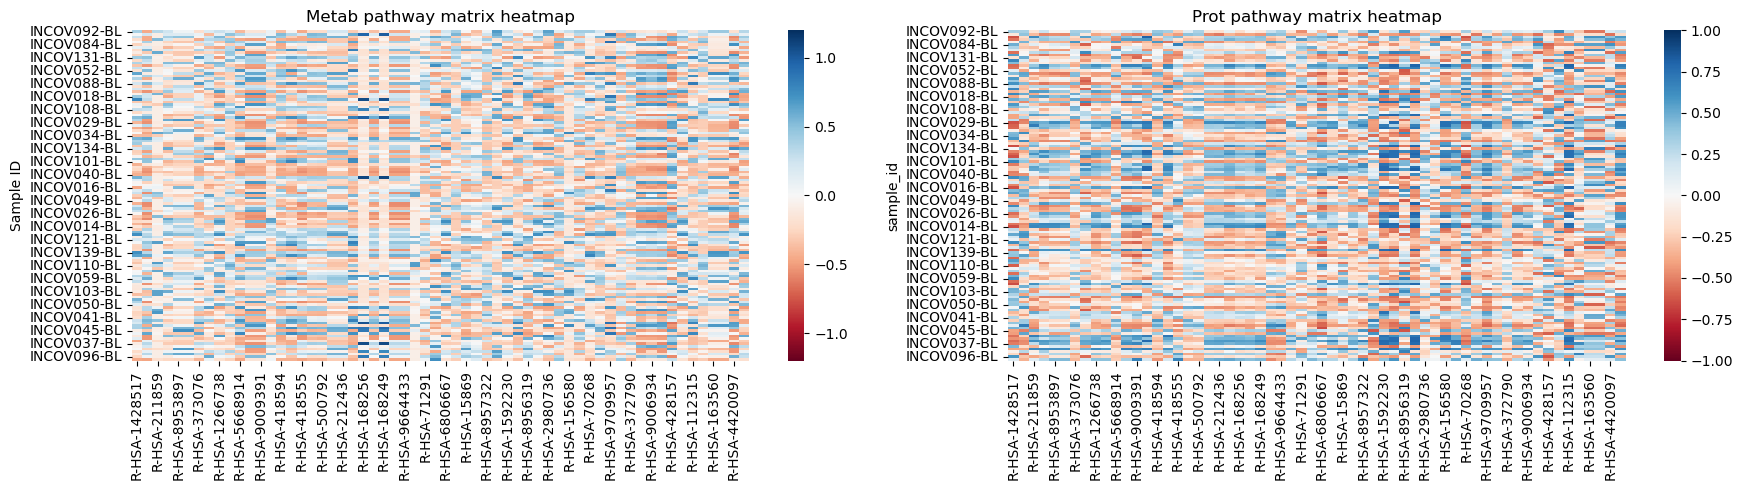

In [52]:
# Visualising the two omics pathway matrices with heatmap
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(metab_filtered_kpca, cmap='RdBu',vmin=-1.2,vmax=1.2)
plt.title('Metab pathway matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(prot_filtered_kpca, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Prot pathway matrix heatmap')


plt.tight_layout()
plt.show()

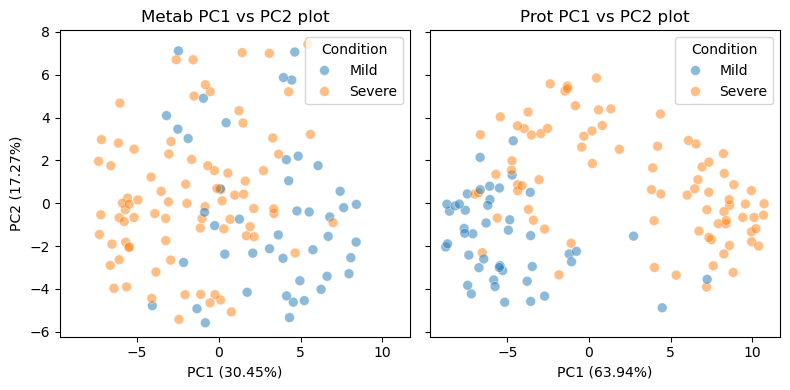

In [157]:
# Proteomics: good recovery, probabily due to a large variance_explained by PC1 (63%)?

metab_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(metab_filtered_kpca), index=metab_filtered_kpca.index,columns=metab_filtered_kpca.columns)

pca_metab = PCA(n_components=2)
pca_metab_res = pca_metab.fit_transform(metab_kpca_scores_norm)

pca_metab.explained_variance_ratio_


prot_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(prot_filtered_kpca), index=prot_filtered_kpca.index,columns=prot_filtered_kpca.columns)

pca_prot = PCA(n_components=2)
pca_prot_res = pca_prot.fit_transform(prot_kpca_scores_norm)

# determine the variance explained by the first 2 components
pca_prot.explained_variance_ratio_

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.scatterplot(x=pca_metab_res[:, 0], y=pca_metab_res[:, 1], hue=metadata_binary, ax=ax1, s=50, alpha=0.5)
sns.scatterplot(x=pca_prot_res[:, 0], y=pca_prot_res[:, 1], hue=metadata_binary, ax=ax2, s=50, alpha=0.5)

# Set axis labels
ax1.set_xlabel('PC1 (' + str(round(pca_metab.explained_variance_ratio_[0]*100,2)) + '%)')
ax1.set_ylabel('PC2 (' + str(round(pca_metab.explained_variance_ratio_[1]*100,2)) + '%)')
ax1.set_title('Metab PC1 vs PC2 plot')

ax2.set_xlabel('PC1 (' + str(round(pca_prot.explained_variance_ratio_[0]*100,2)) + '%)')
ax2.set_ylabel('PC2 (' + str(round(pca_prot.explained_variance_ratio_[1]*100,2)) + '%)')
ax2.set_title('Prot PC1 vs PC2 plot')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=['Mild', 'Severe'], title='Condition', loc='upper right')  # Customize legend for ax1
ax2.legend(title='Condition', loc='upper right', handles=handles, labels=['Mild', 'Severe'])  # Same legend for ax2

plt.tight_layout()

plt.show()


- preprocessing tensor

In [303]:
mat_to_be_processed = pd.concat([metab_filtered_kpca,prot_filtered_kpca],axis=1)

matrix_centered = mat_to_be_processed - mat_to_be_processed.mean()

from sklearn.preprocessing import scale
matrix_bro_scaled = scale(matrix_centered,axis=1, with_mean=False)

pred_metab_kpca = pd.DataFrame(matrix_bro_scaled[:,:60], index=metab_filtered_kpca.index, columns = metab_filtered_kpca.columns)
pred_prot_kpca = pd.DataFrame(matrix_bro_scaled[:,60:], index=metab_filtered_kpca.index, columns = metab_filtered_kpca.columns)

# Folding preprocessed matrix into tensor
X_cen_bro = tl.fold(matrix_bro_scaled, mode=0, shape=(127,60,2))

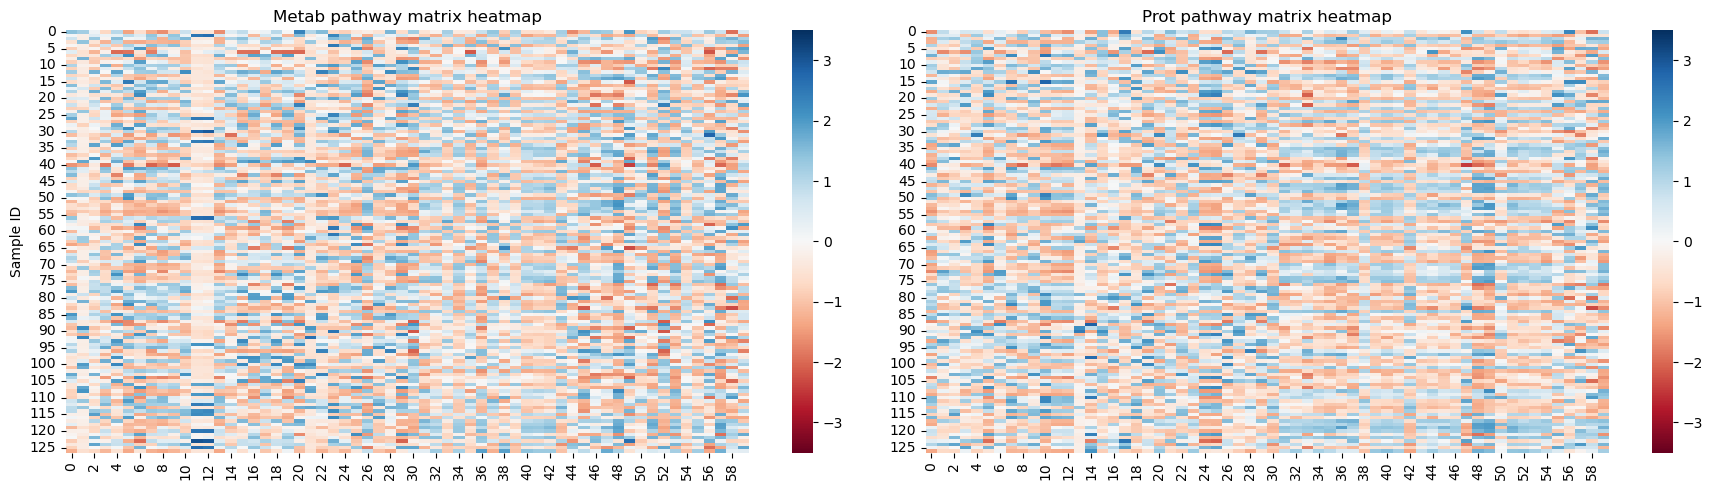

In [54]:
# Visualising the two cen_bro PREPROCESSED omics pathway matrices with heatmap
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(X_cen_bro[:,:,0], cmap='RdBu',vmax=3.5, vmin=-3.5)
plt.title('Metab pathway matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(X_cen_bro[:,:,1], cmap='RdBu',vmax=3.5, vmin=-3.5)
plt.title('Prot pathway matrix heatmap')


plt.tight_layout()
plt.show()

In [141]:
with open('p2_all_r2x_dict.pkl','rb') as f:
    p2_all_r2x_dict = pickle.load(f)

In [142]:
with open('p2_common_r2x_dict.pkl','rb') as f:
    p2_common_r2x_dict = pickle.load(f)

array([0.27286554, 0.41004592, 0.47298475, 0.53108789, 0.57516117,
       0.61593046, 0.6527038 , 0.68290747, 0.70810664, 0.73156146])

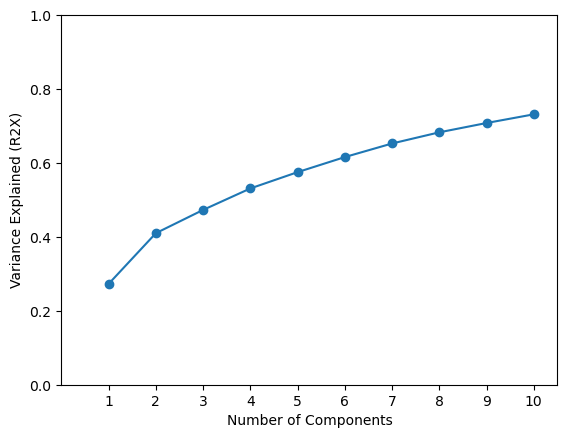

In [139]:
# Investigate variance explained by components across rank=range(1,11)
# It is just our 'fit' evaluation metric
# Code adapted from https://tensorly.org/stable/auto_examples/applications/plot_covid.html

comps = np.arange(1, 11)
CMTFfacs = [
    parafac(
        X_cen_bro, rank
    )
    for rank in comps
]

def reconstructed_variance(tFac, tIn=None): #tFac: the tensor factorisation result; tIn: the original tensor
    """This function calculates the amount of variance captured (R2X) by the tensor method."""
    tMask = np.isfinite(tIn) # Create a mask of valid entries
    vTop = np.sum(np.square(tl.cp_to_tensor(tFac) * tMask - np.nan_to_num(tIn)))
    vBottom = np.sum(np.square(np.nan_to_num(tIn)))
    return 1.0 - vTop / vBottom


fig1 = plt.figure()
CMTFR2X = np.array([reconstructed_variance(f, X_cen_bro) for f in CMTFfacs])

plt.plot(comps, CMTFR2X, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained (R2X)")
plt.gca().set_xlim([0.0, np.amax(comps) + 0.5])
plt.gca().set_ylim([0, 1])
plt.xticks(comps)
CMTFR2X

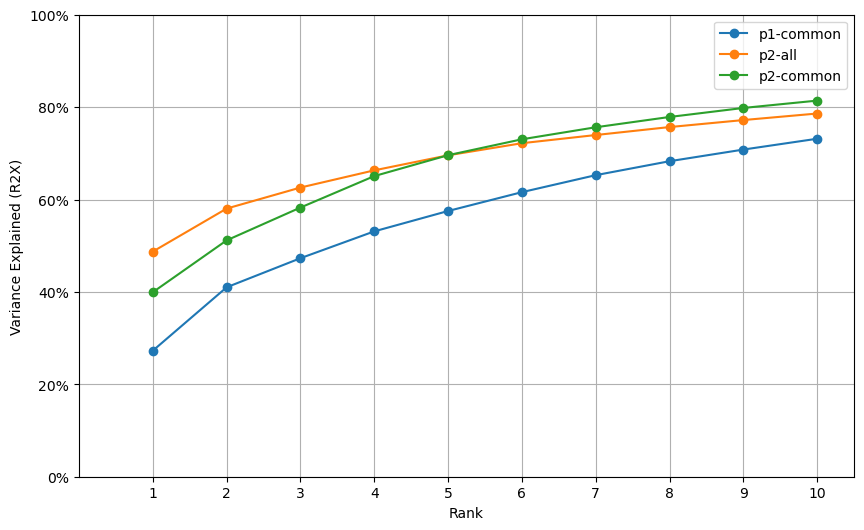

In [154]:
p2_all_r2x_values = [p2_all_r2x_dict[rank] for rank in comps]
p2_common_r2x_values = [p2_common_r2x_dict[rank] for rank in comps]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plotting the first line for CMTFR2X
plt.plot(comps, CMTFR2X, marker='o', linestyle='-', color='#1f77b4', label='p1-common')  # Blue

# Plotting the second line for p2_all_r2x_dict
plt.plot(comps, p2_all_r2x_values, marker='o', linestyle='-', color='#ff7f0e', label='p2-all')  # Orange

# Plotting the third line for p2_common_r2x_dict
plt.plot(comps, p2_common_r2x_values, marker='o', linestyle='-', color='#2ca02c', label='p2-common')  # Green

plt.xlabel("Rank")
plt.ylabel("Variance Explained (R2X)")
plt.gca().set_xlim([0.0, np.amax(comps) + 0.5])
plt.gca().set_ylim([0, 1])
plt.xticks(comps)

# Set y-ticks to display as percentages
y_ticks = plt.gca().get_yticks()  # Get current y-ticks
plt.yticks(y_ticks, [f'{int(y * 100)}%' for y in y_ticks])  # Convert to percentage format

plt.legend()  # Show legend to differentiate between lines
plt.grid(True)  # Optional: Adds a grid to the plot

plt.show()  # Displays the plot

#### PCA on metab_filtered_kpca and prot_filtered_kpca

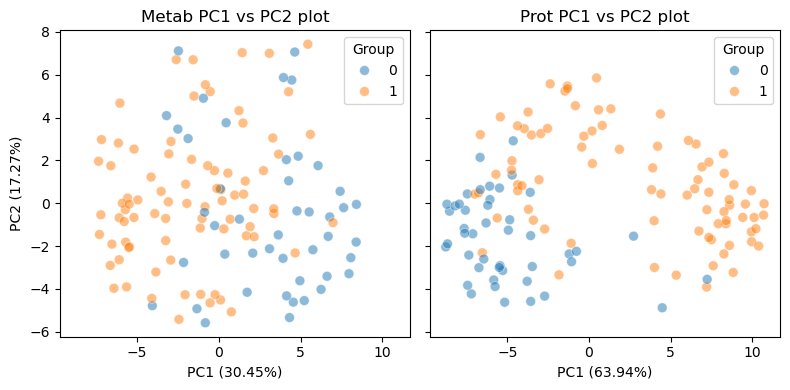

In [56]:
# Proteomics: good recovery, probably due to a large variance_explained by PC1 (63%)?

metab_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(metab_filtered_kpca), index=metab_filtered_kpca.index,columns=metab_filtered_kpca.columns)

pca_metab = PCA(n_components=2)
pca_metab_res = pca_metab.fit_transform(metab_kpca_scores_norm)

pca_metab.explained_variance_ratio_


prot_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(prot_filtered_kpca), index=prot_filtered_kpca.index,columns=prot_filtered_kpca.columns)

pca_prot = PCA(n_components=2)
pca_prot_res = pca_prot.fit_transform(prot_kpca_scores_norm)

# determine the variance explained by the first 2 components
pca_prot.explained_variance_ratio_

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.scatterplot(x=pca_metab_res[:, 0], y=pca_metab_res[:, 1], hue=metadata_binary, ax=ax1, s=50, alpha=0.5)
sns.scatterplot(x=pca_prot_res[:, 0], y=pca_prot_res[:, 1], hue=metadata_binary, ax=ax2, s=50, alpha=0.5)

# Set axis labels
ax1.set_xlabel('PC1 (' + str(round(pca_metab.explained_variance_ratio_[0]*100,2)) + '%)')
ax1.set_ylabel('PC2 (' + str(round(pca_metab.explained_variance_ratio_[1]*100,2)) + '%)')
ax1.set_title('Metab PC1 vs PC2 plot')

ax2.set_xlabel('PC1 (' + str(round(pca_prot.explained_variance_ratio_[0]*100,2)) + '%)')
ax2.set_ylabel('PC2 (' + str(round(pca_prot.explained_variance_ratio_[1]*100,2)) + '%)')
ax2.set_title('Prot PC1 vs PC2 plot')


plt.tight_layout()

plt.show()


#### Evaluation metrics

In [57]:
evaluation_metrics = df_rank_evaluation(X_cen_bro,10,metadata_binary,LinearRegression())

In [58]:
evaluation_metrics

Core consistency       Fit  Sum Squared Error  \
Number of components                                                  
1                           100.000000  0.272866       11446.937771   
2                            99.999170  0.410046        9287.371264   
3                            64.785913  0.472961        8296.925891   
4                             5.110118  0.530874        7385.233505   
5                           -63.558974  0.572553        6729.099992   
6                            32.247752  0.616410        6038.682015   
7                           -25.447404  0.645365        5582.845274   
8                            14.170662  0.682543        4997.583754   
9                           -45.981315  0.706945        4613.421490   
10                           13.392513  0.731477        4227.232031   

                      Predictive Power  Degeneracy Score  
Number of components                                      
1                             0.236606          1.000000  
2                             0.508748          0.126243  
3                             0.589616          0.206204  
4                             0.574535          0.878130  
5                             0.583152          0.540148  
6                             0.626969          0.525331  
7                             0.628381          0.698781  
8                             0.649019          0.480617  
9                             0.669942          0.604674  
10                            0.701680          0.434686

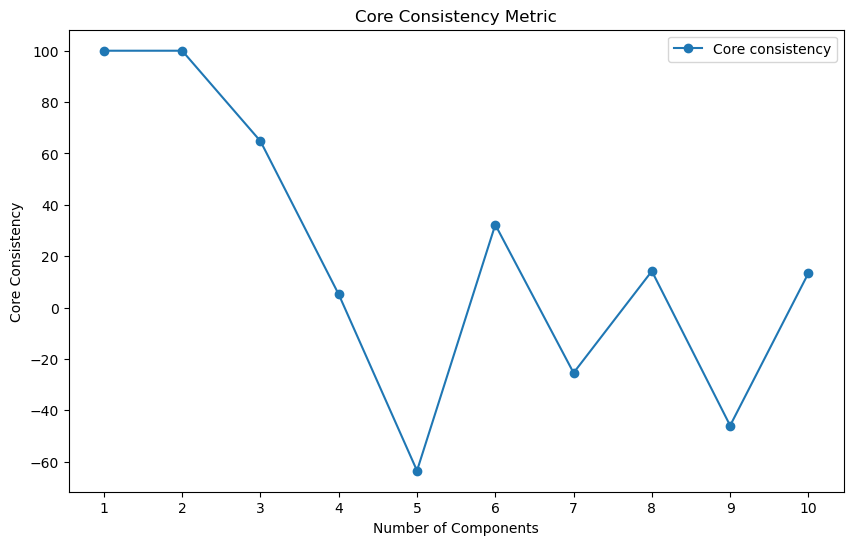

In [136]:
plt.figure(figsize=(10, 6))

# Plotting the 'Core consistency' column
plt.plot(evaluation_metrics.index, evaluation_metrics['Core consistency'], label='Core consistency', marker='o')
plt.xticks(evaluation_metrics.index)
# Adding title and labels
plt.title('Core Consistency Metric')
plt.xlabel('Number of Components')
plt.ylabel('Core Consistency')
plt.legend()


plt.show()

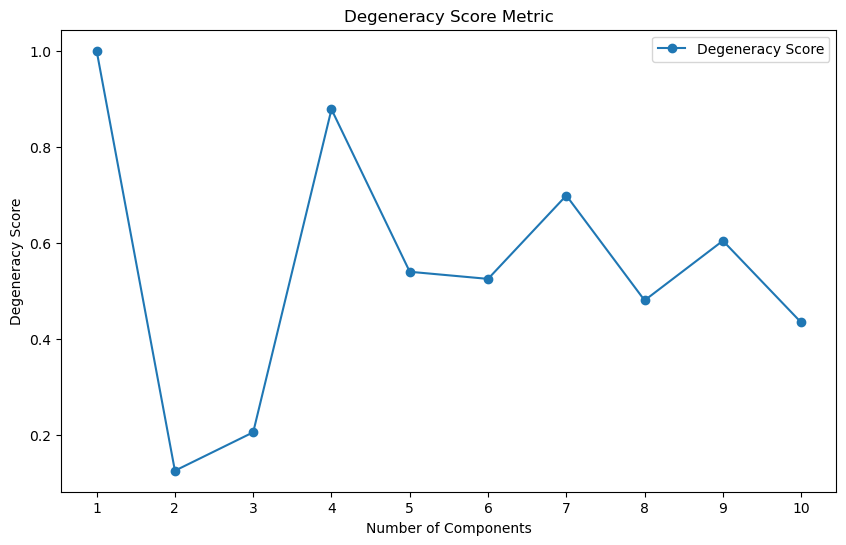

In [137]:
plt.figure(figsize=(10, 6))

plt.plot(evaluation_metrics.index, evaluation_metrics['Degeneracy Score'], label='Degeneracy Score', marker='o')
plt.xticks(evaluation_metrics.index)
# Adding title and labels
plt.title('Degeneracy Score Metric')
plt.xlabel('Number of Components')
plt.ylabel('Degeneracy Score')
plt.legend()


plt.show()

#### Decompose at higher ranks

- decompose at rank =3

In [59]:
weight_r3, cp_tensor_r3 = parafac(X_cen_bro,3, n_iter_max=10000, tol=1e-14, random_state=28)
sample_mat_r3,pathway_mat_r3,omic_mat_r3 = cp_tensor_r3

In [60]:
df_sample_r3 = pd.DataFrame(sample_mat_r3,index=metab.index, columns = [f"Factor {i}" for i in range(1,4)])

df_pathway_r3 = pd.DataFrame(pathway_mat_r3,index=common_pathways, columns = [f"Factor {i}" for i in range(1,4)])

df_omic_r3 = pd.DataFrame(omic_mat_r3,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,4)])

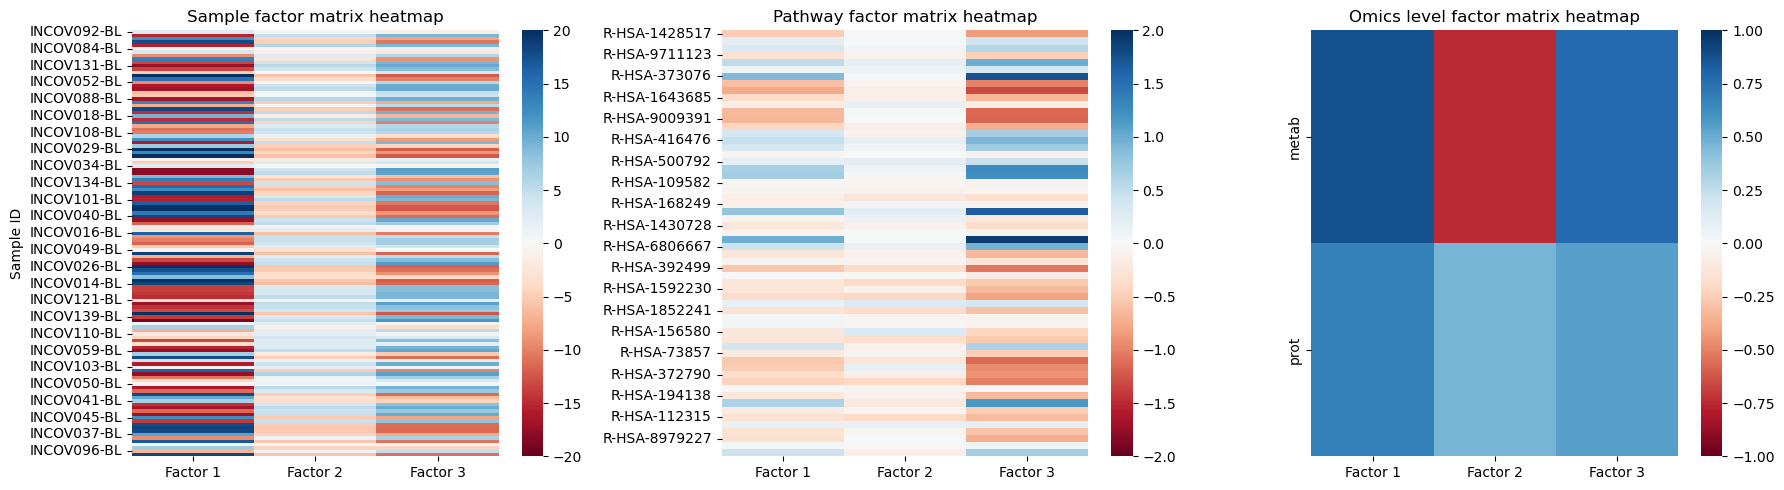

In [61]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.heatmap(df_sample_r3, cmap='RdBu',vmin=-20,vmax=20)
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,3,2)
sns.heatmap(df_pathway_r3, cmap='RdBu',vmin=-2,vmax=2)
plt.title('Pathway factor matrix heatmap')

plt.subplot(1,3,3)
sns.heatmap(df_omic_r3, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample factor matrix heatmap')

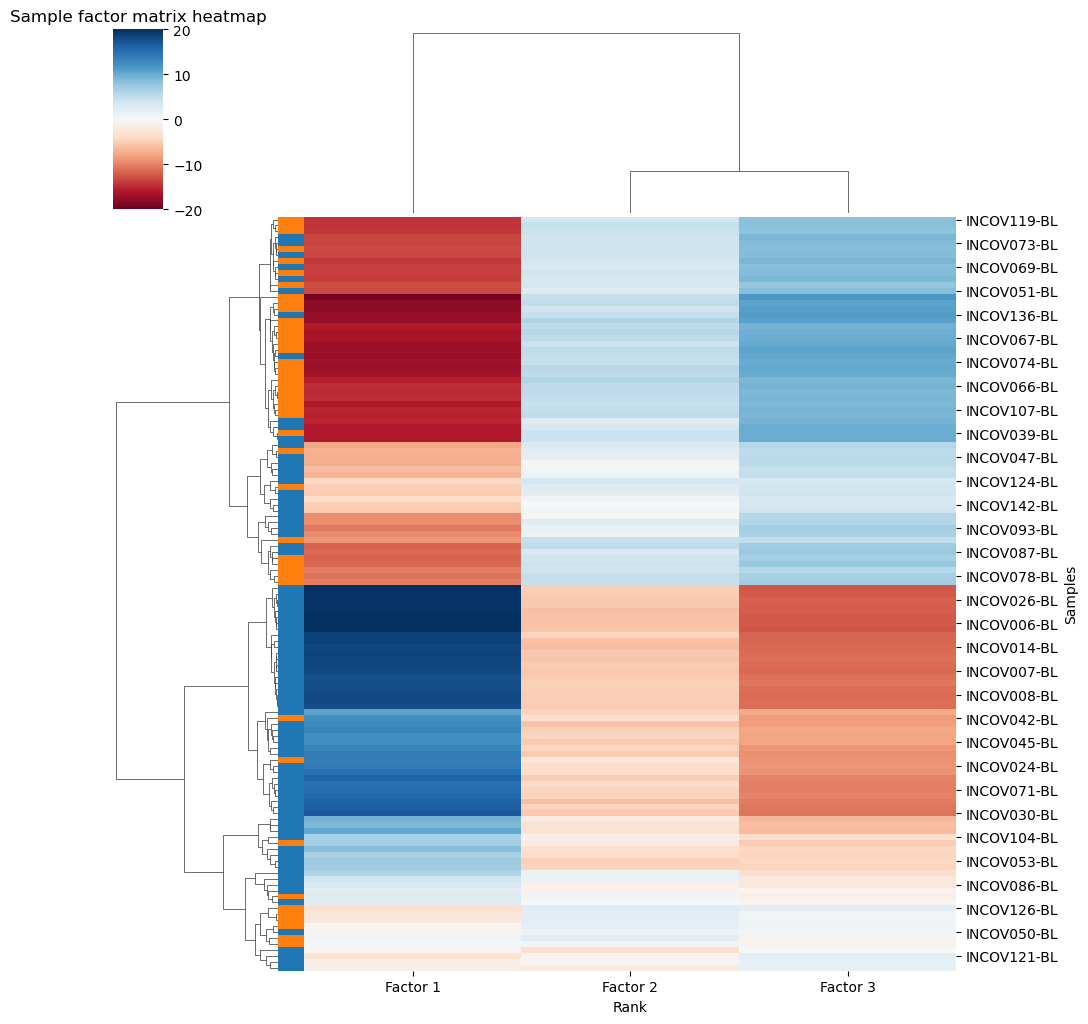

In [62]:
g=sns.clustermap(df_sample_r3, 
               cmap='RdBu',vmin=-20,vmax=20,
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

Text(0.5, 1.0, 'Sample factor matrix heatmap')

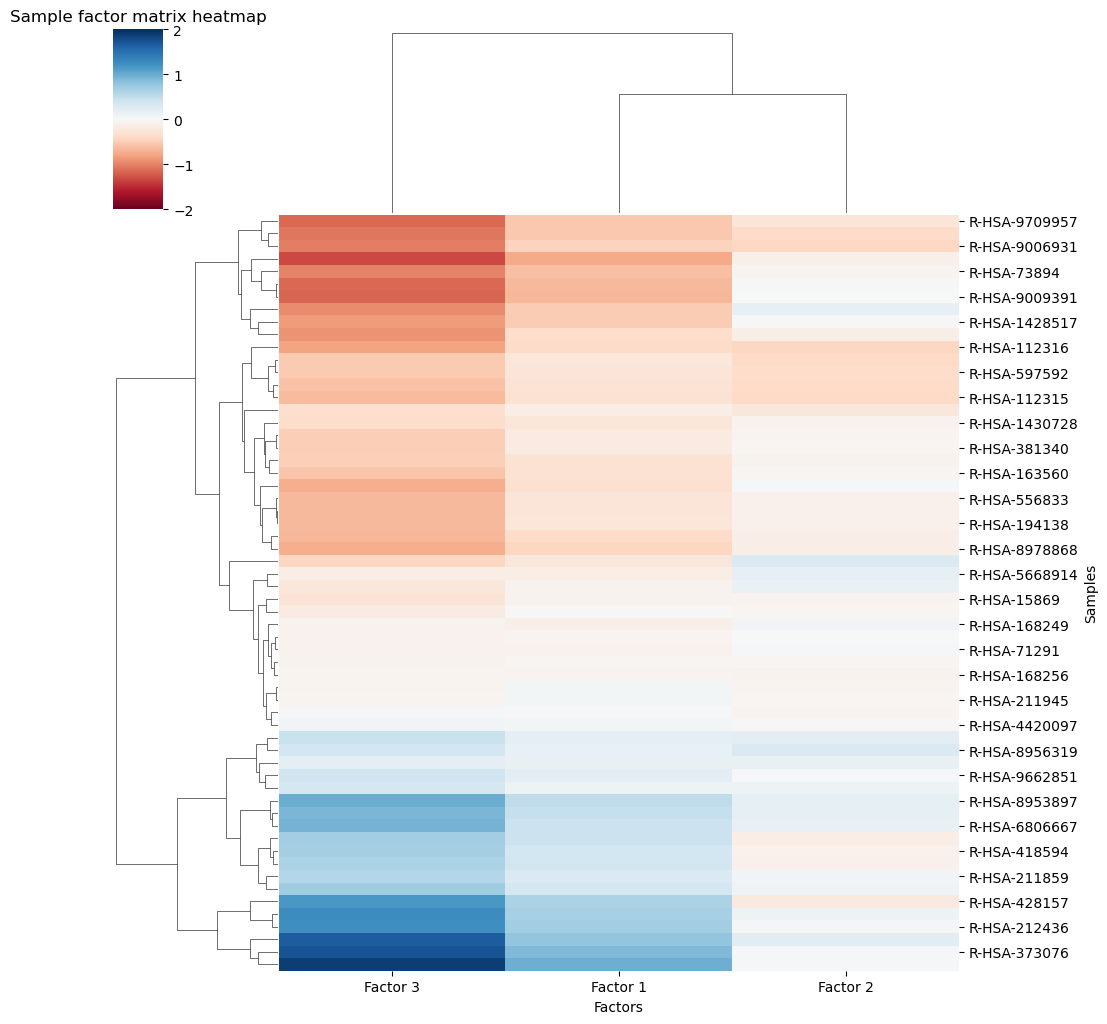

In [63]:
g=sns.clustermap(df_pathway_r3, 
               cmap='RdBu',vmin=-2,vmax=2,)
g.ax_heatmap.set_xlabel("Factors")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

In [64]:
weight_r4, cp_tensor_r4 = parafac(X_cen_bro,4, n_iter_max=10000, tol=1e-14, random_state=28)
sample_matrix,pathway_matrix,omic_matrix = cp_tensor_r4

df_sample = pd.DataFrame(sample_matrix,index=metab.index, columns = [f"Factor {i}" for i in range(1,5)])

df_pathway = pd.DataFrame(pathway_matrix,index=common_pathways, columns = [f"Factor {i}" for i in range(1,5)])

df_omic = pd.DataFrame(omic_matrix,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,5)])

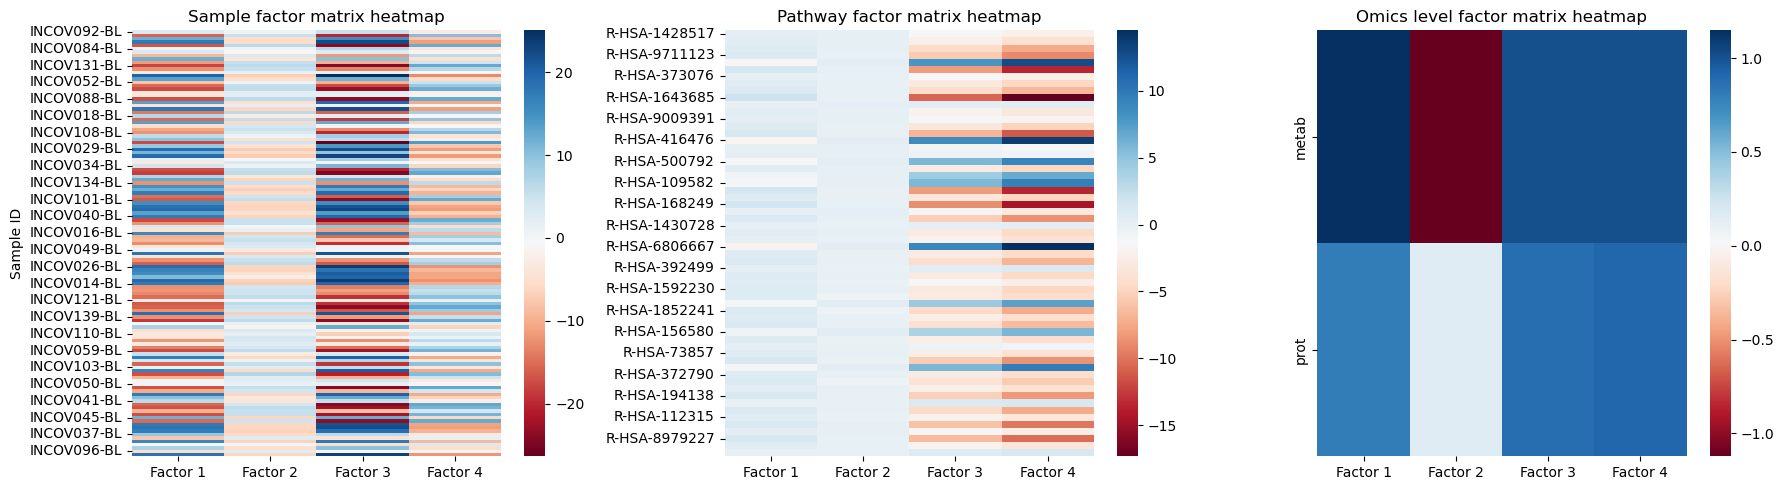

In [65]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.heatmap(df_sample, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,3,2)
sns.heatmap(df_pathway, cmap='RdBu')
plt.title('Pathway factor matrix heatmap')

plt.subplot(1,3,3)
sns.heatmap(df_omic, cmap='RdBu')
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample factor matrix heatmap')

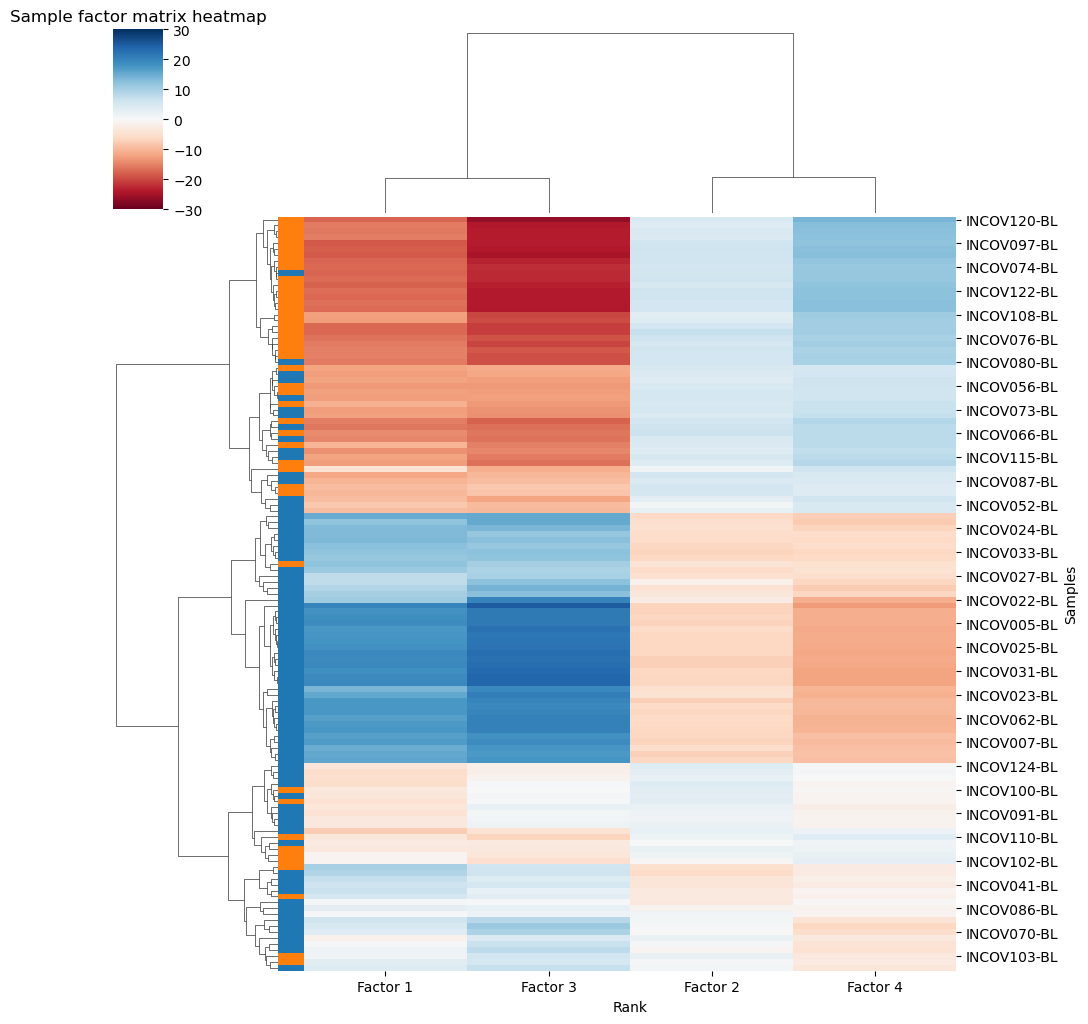

In [66]:
g=sns.clustermap(df_sample, 
               cmap='RdBu',vmin=-30,vmax=30,
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


Text(0.5, 1.0, 'Sample factor matrix heatmap')

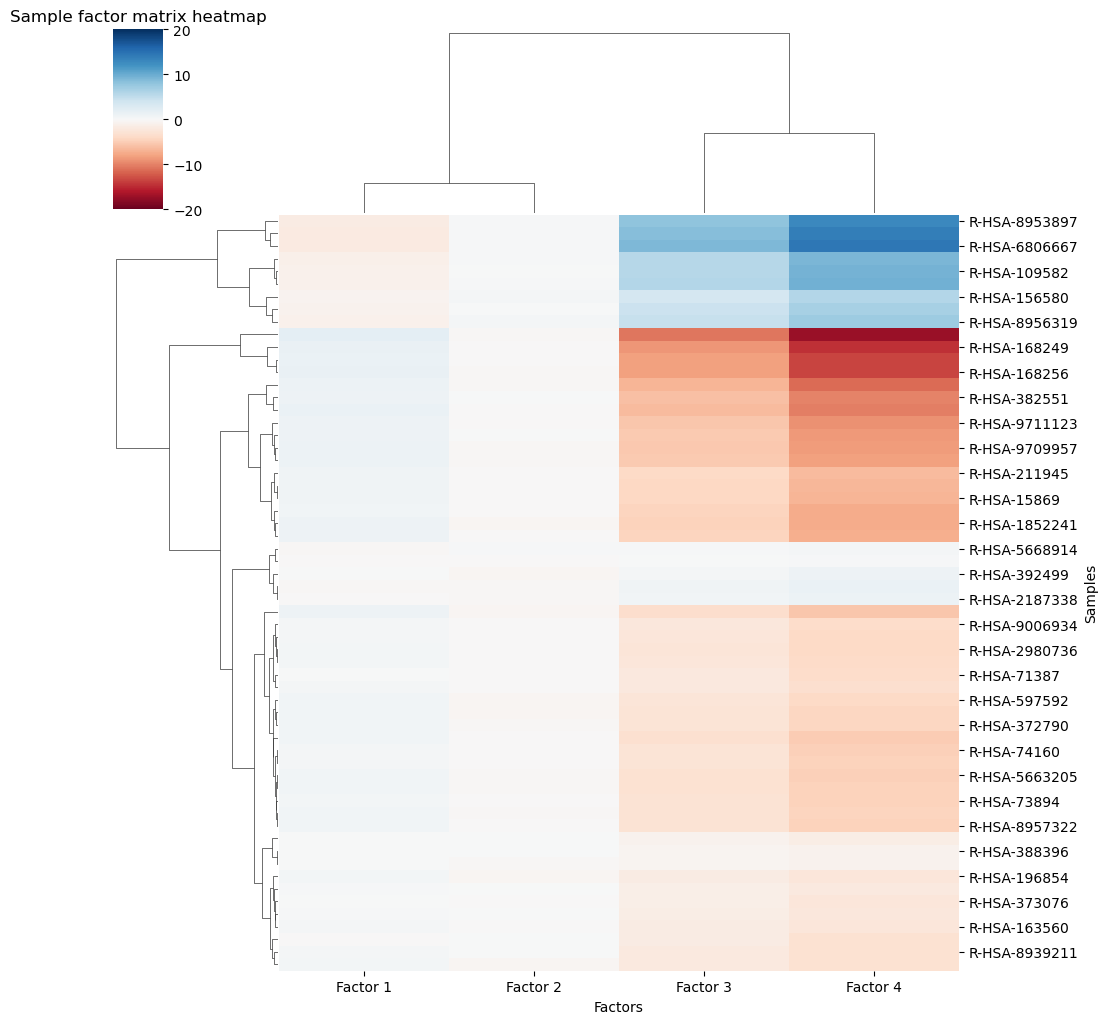

In [67]:
g=sns.clustermap(df_pathway, 
               cmap='RdBu',vmin=-20,vmax=20)
g.ax_heatmap.set_xlabel("Factors")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

Text(0.5, 1.0, 'Sample factor matrix heatmap')

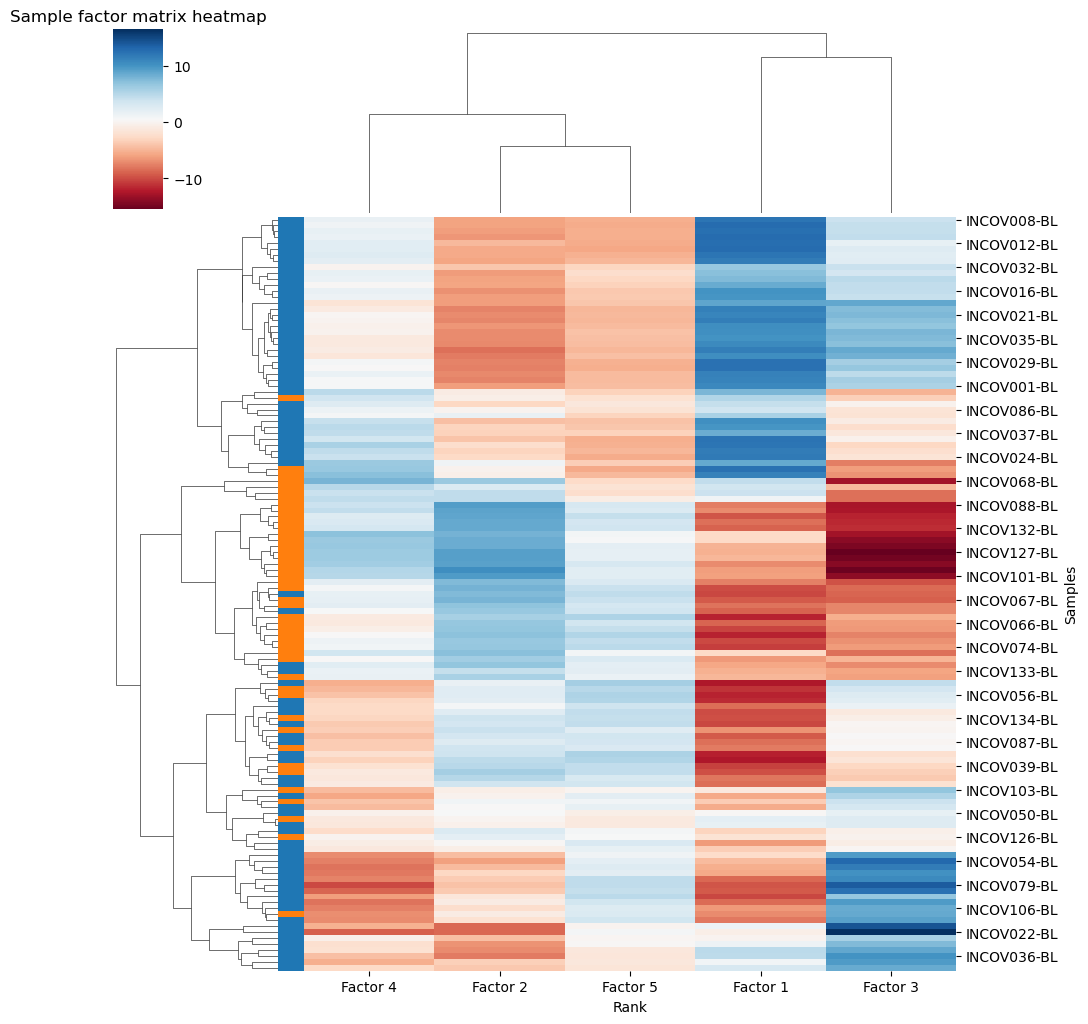

In [68]:
weight, cp_tensor_r5 = parafac(X_cen_bro,5, n_iter_max=10000, tol=1e-14, random_state=28)
sample_matrix,pathway_matrix,omic_matrix = cp_tensor_r5

df_sample = pd.DataFrame(sample_matrix,index=metab.index, columns = [f"Factor {i}" for i in range(1,6)])

df_pathway = pd.DataFrame(pathway_matrix,index=common_pathways, columns = [f"Factor {i}" for i in range(1,6)])

df_omic = pd.DataFrame(omic_matrix,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,6)])

g=sns.clustermap(df_sample, 
               cmap='RdBu',
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


Text(0.5, 1.0, 'Sample factor matrix heatmap')

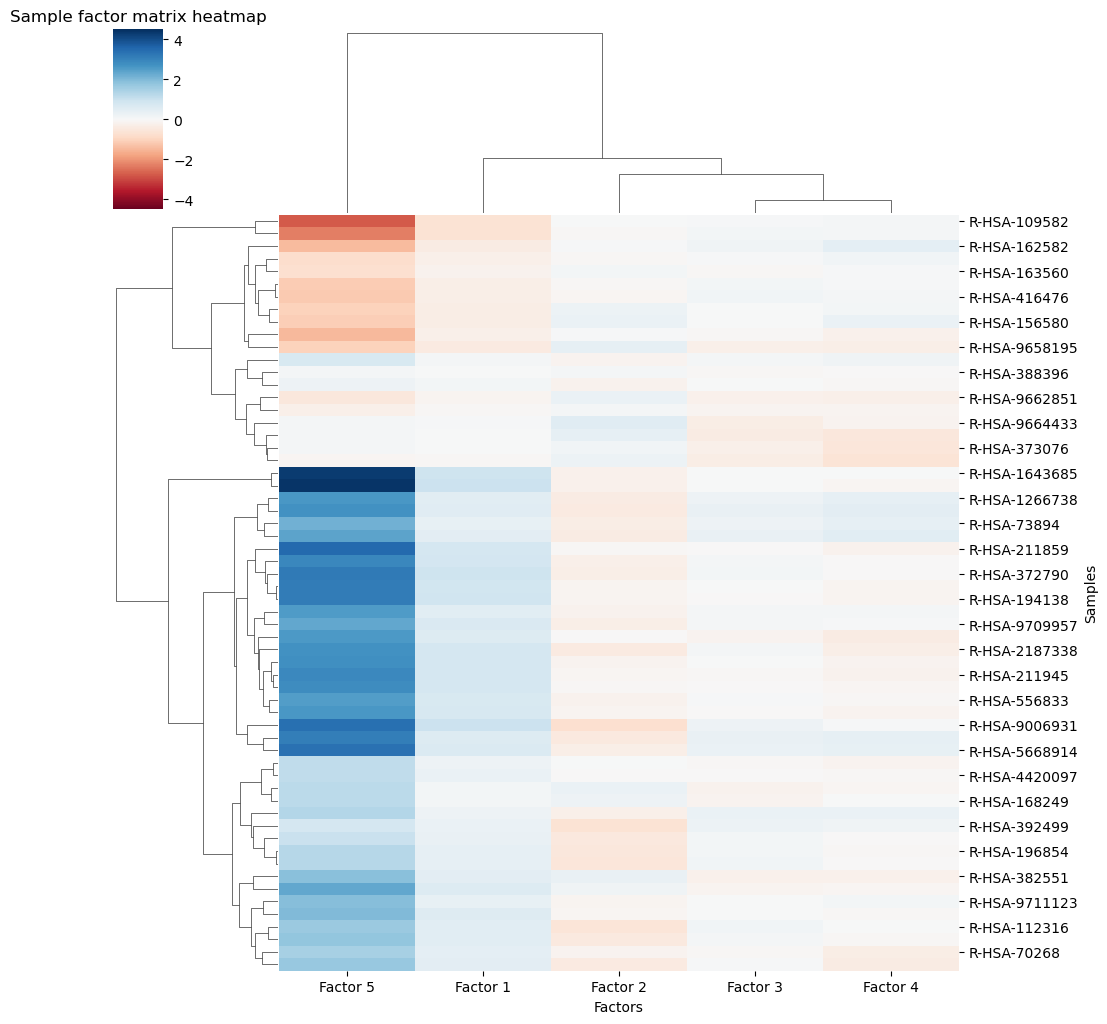

In [69]:
g=sns.clustermap(df_pathway, 
               cmap='RdBu',vmin=-4.5,vmax=4.5)
g.ax_heatmap.set_xlabel("Factors")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

Text(0.5, 1.0, 'Sample factor matrix heatmap')

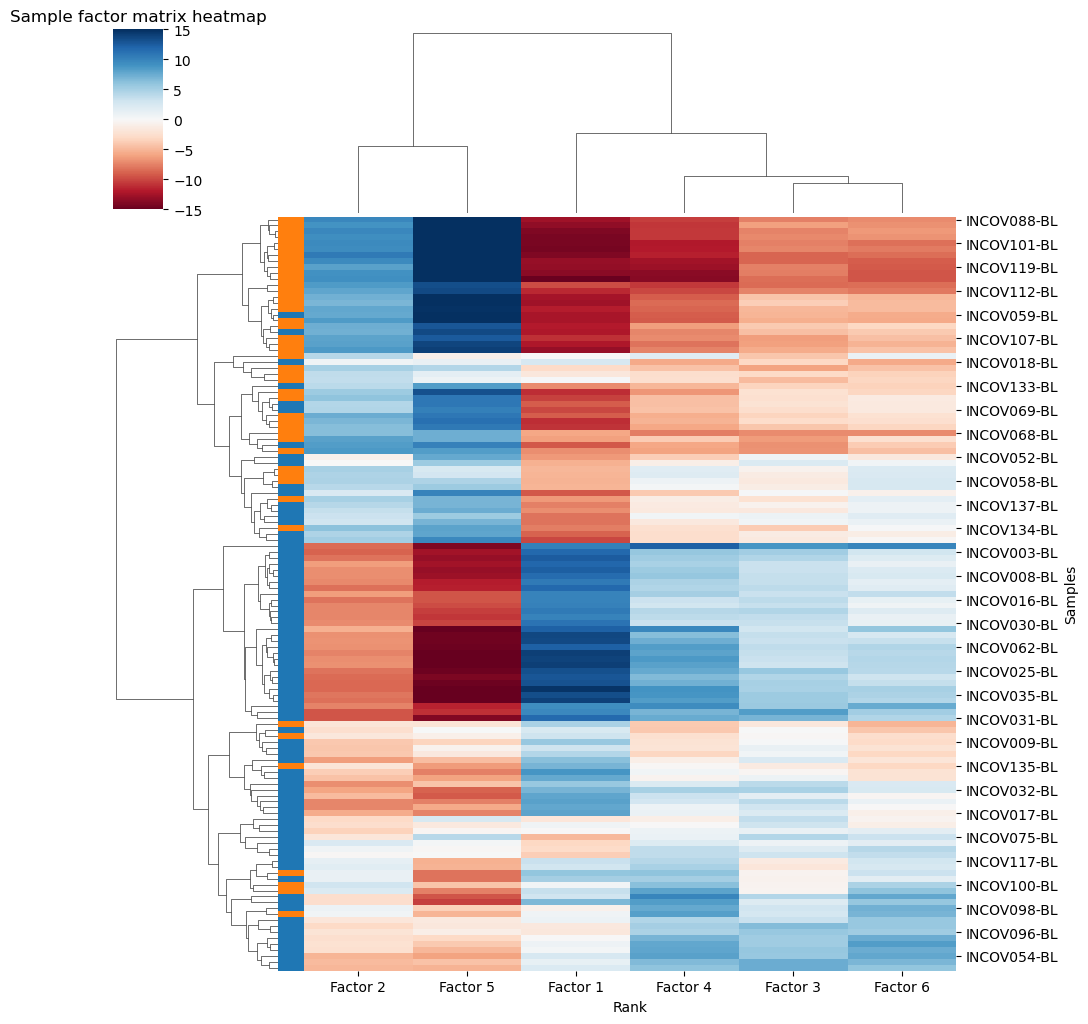

In [70]:
weight, cp_tensor_r6 = parafac(X_cen_bro,6, n_iter_max=10000, tol=1e-14, random_state=28)
sample_matrix,pathway_matrix,omic_matrix = cp_tensor_r6

df_sample = pd.DataFrame(sample_matrix,index=metab.index, columns = [f"Factor {i}" for i in range(1,7)])

df_pathway = pd.DataFrame(pathway_matrix,index=common_pathways, columns = [f"Factor {i}" for i in range(1,7)])

df_omic = pd.DataFrame(omic_matrix,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,7)])

g=sns.clustermap(df_sample, 
               cmap='RdBu', vmin=-15,vmax=15,
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


Text(0.5, 1.0, 'Sample factor matrix heatmap')

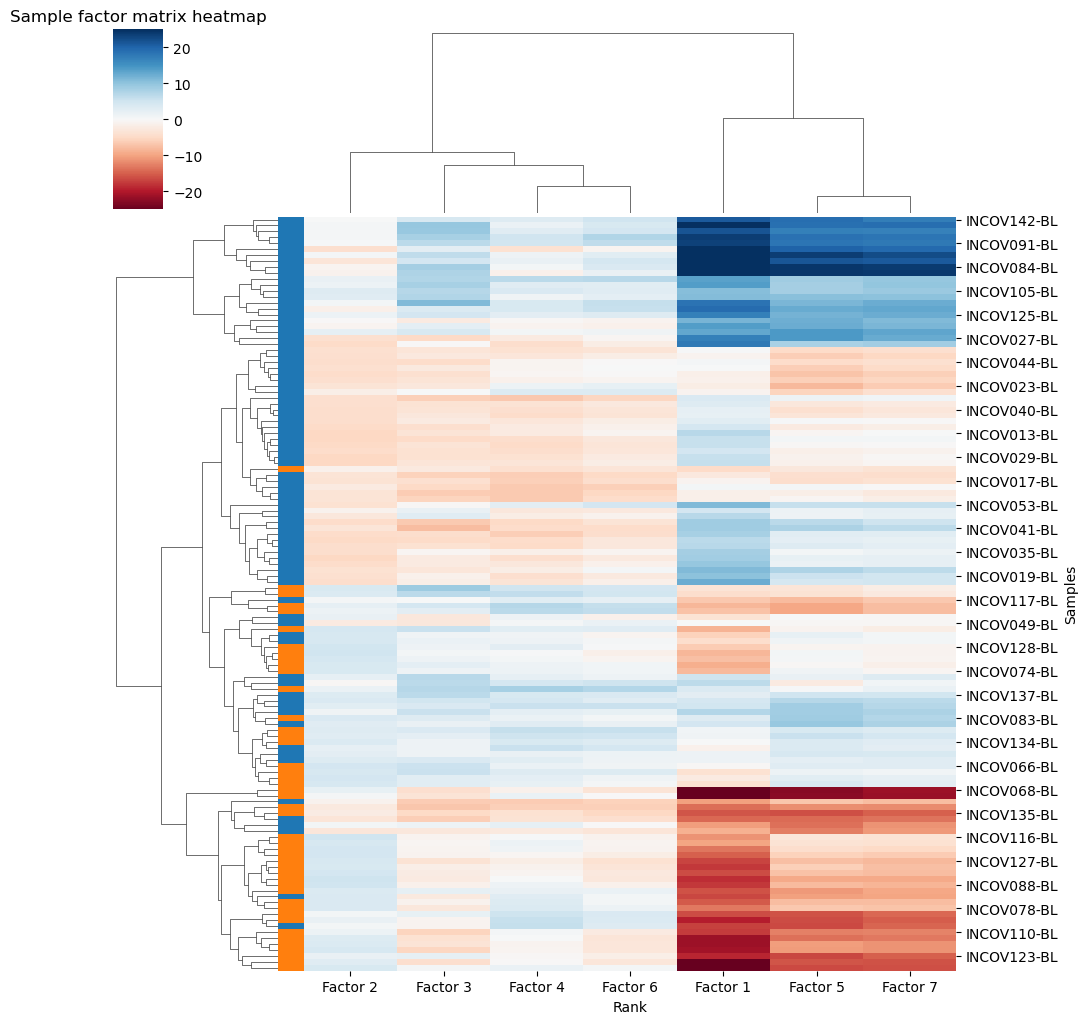

In [71]:
weight, cp_tensor_r7 = parafac(X_cen_bro,7, n_iter_max=10000, tol=1e-14, random_state=28)
sample_matrix,pathway_matrix,omic_matrix = cp_tensor_r7

df_sample = pd.DataFrame(sample_matrix,index=metab.index, columns = [f"Factor {i}" for i in range(1,8)])

df_pathway = pd.DataFrame(pathway_matrix,index=common_pathways, columns = [f"Factor {i}" for i in range(1,8)])

df_omic = pd.DataFrame(omic_matrix,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,8)])

g=sns.clustermap(df_sample, 
               cmap='RdBu',vmin=-25,vmax=25,
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


Text(0.5, 1.0, 'Sample factor matrix heatmap')

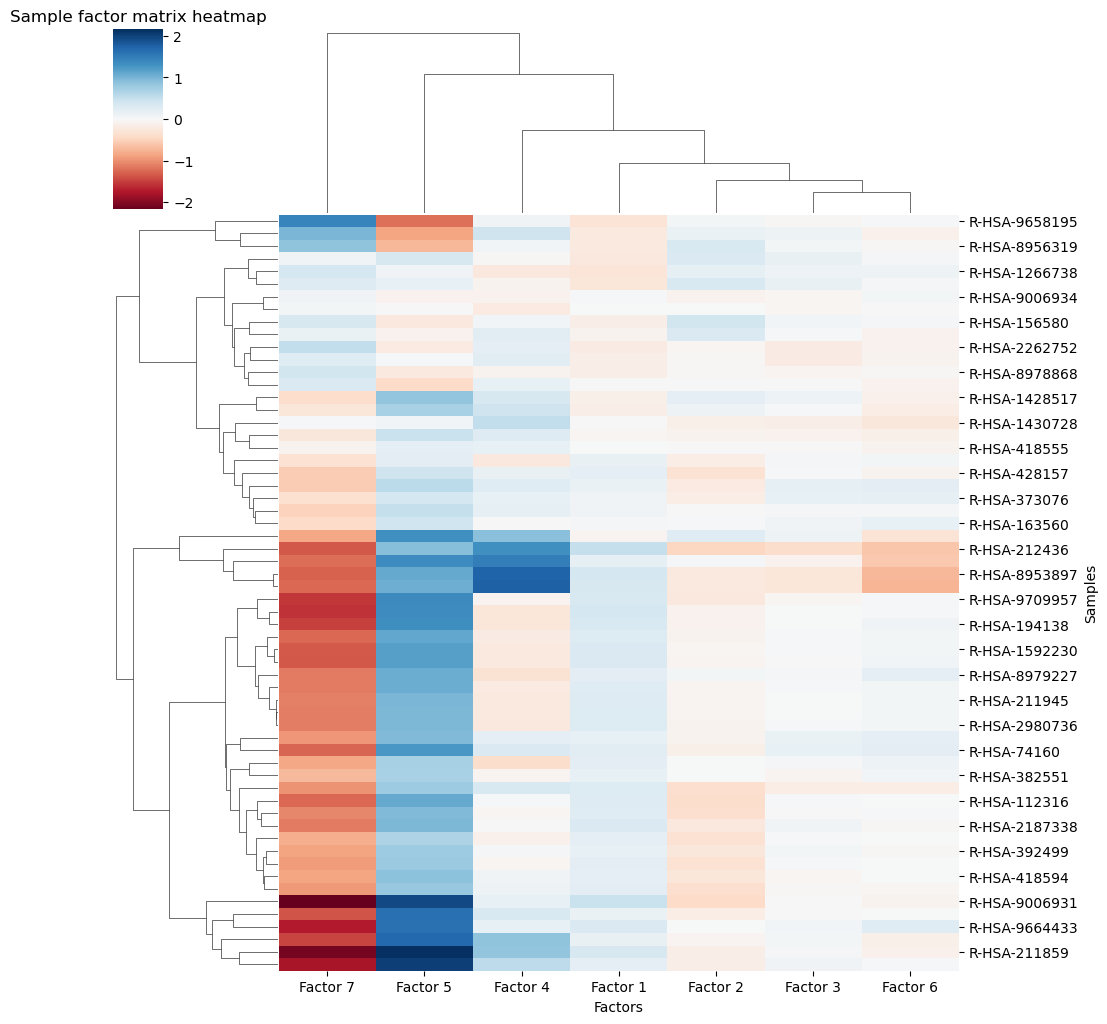

In [72]:
g=sns.clustermap(df_pathway, 
               cmap='RdBu')
g.ax_heatmap.set_xlabel("Factors")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

Text(0.5, 1.0, 'Sample factor matrix heatmap')

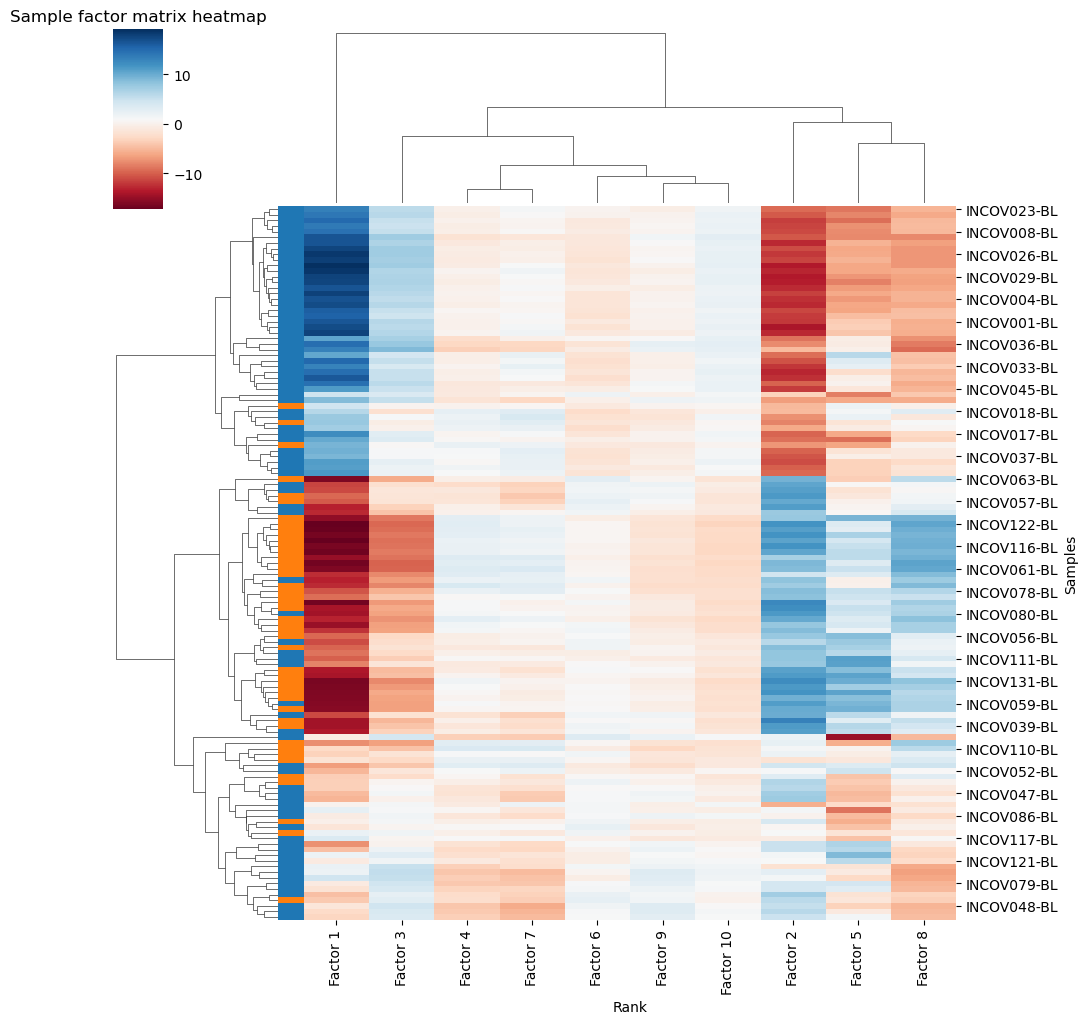

In [73]:
weight_r10, cp_tensor_r10 = parafac(X_cen_bro,10, n_iter_max=10000, tol=1e-14, random_state=28)
sample_mat_r10,pathway_mat_r10,omic_mat_r10 = cp_tensor_r10

df_sample_r10 = pd.DataFrame(sample_mat_r10,index=metab.index, columns = [f"Factor {i}" for i in range(1,11)])

df_pathway_r10 = pd.DataFrame(pathway_mat_r10,index=common_pathways, columns = [f"Factor {i}" for i in range(1,11)])

df_omic_r10 = pd.DataFrame(omic_mat_r10,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,11)])

g=sns.clustermap(df_sample_r10, 
               cmap='RdBu',
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


<Axes: >

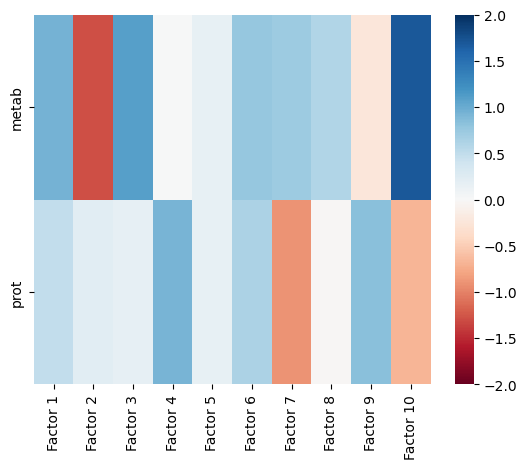

In [74]:
sns.heatmap(df_omic_r10,cmap='RdBu',vmin=-2,vmax=2)

Text(0.5, 1.0, 'Sample factor matrix heatmap')

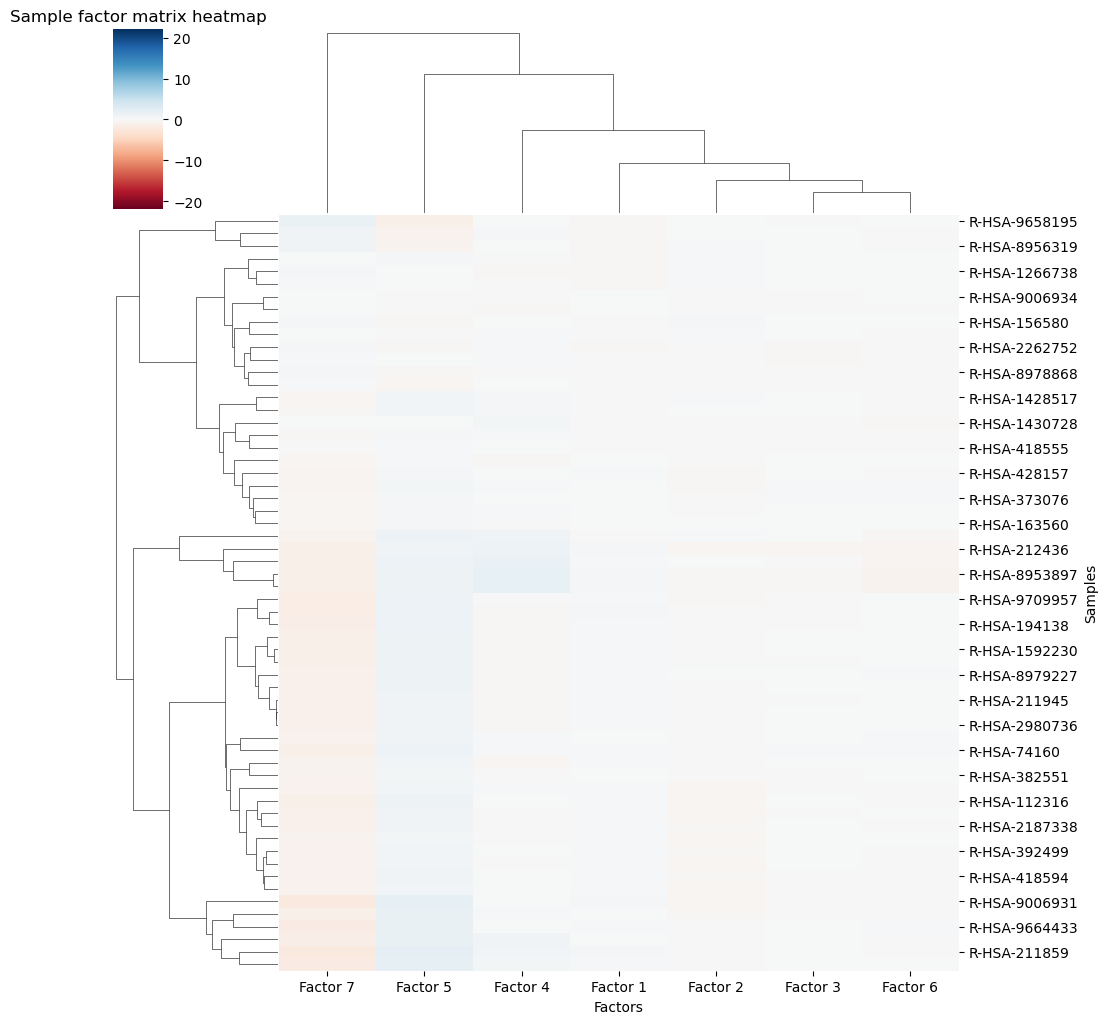

In [75]:
g=sns.clustermap(df_pathway, 
               cmap='RdBu',vmin=-22,vmax=22)
g.ax_heatmap.set_xlabel("Factors")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')

#### Decompose at rank=2

Text(0.5, 1.0, 'Sample factor matrix heatmap')

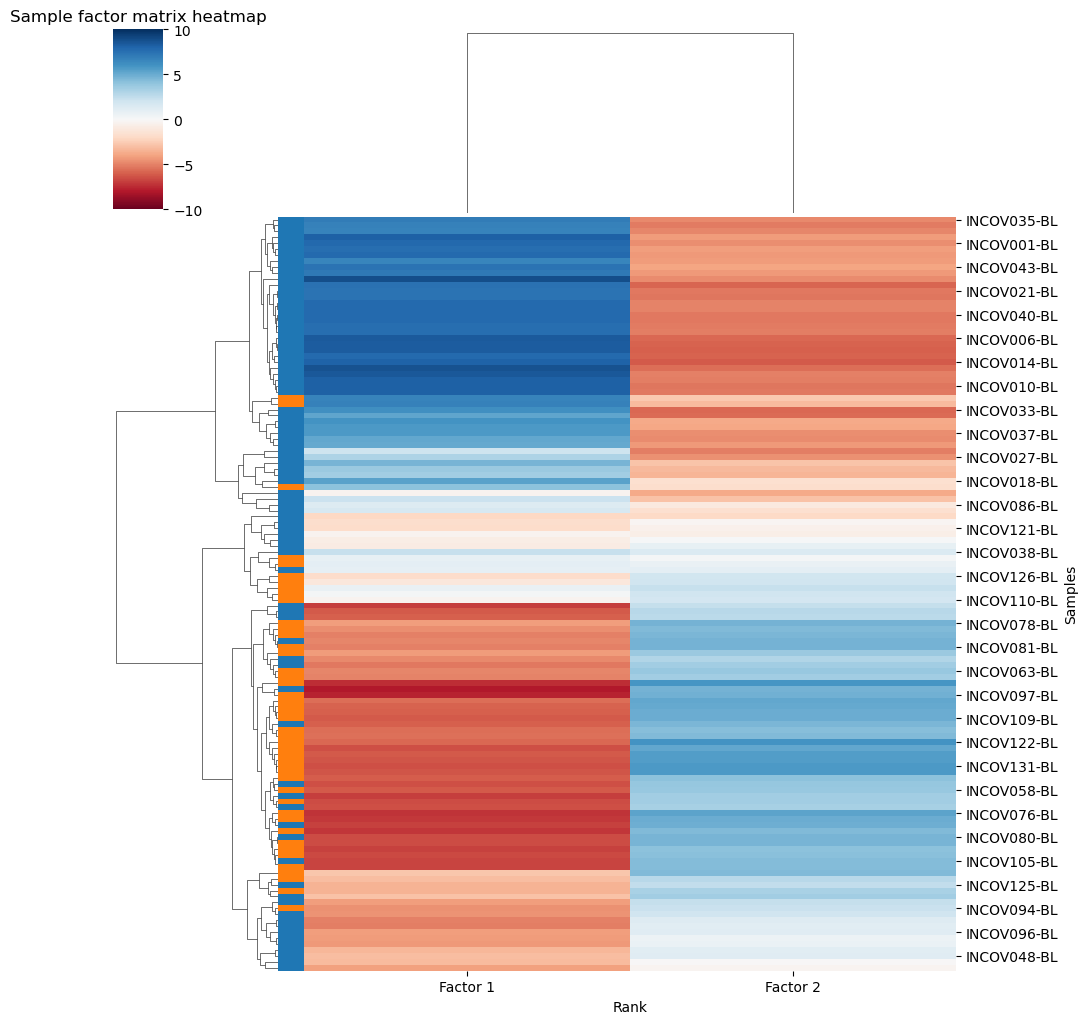

In [76]:
weight_r2, cp_tensor_r2 = parafac(X_cen_bro,2, init='svd',random_state=28)
sample_mat_r2,pathway_mat_r2,omic_mat_r2 = cp_tensor_r2

df_sample_r2 = pd.DataFrame(sample_mat_r2,index=metab.index, columns = [f"Factor {i}" for i in range(1,3)])

df_pathway_r2 = pd.DataFrame(pathway_mat_r2,index=common_pathways, columns = [f"Factor {i}" for i in range(1,3)])

df_omic_r2 = pd.DataFrame(omic_mat_r2,index=['metab','prot'], columns = [f"Factor {i}" for i in range(1,3)])

g=sns.clustermap(df_sample_r2, 
               cmap='RdBu',vmin=-10,vmax=10,
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


In [77]:
with open('p1_df_sample_r2.pkl', 'wb') as f:
    pickle.dump(df_sample_r2, f)

#### Logistic regression on individual sample factor scores / using both factor scores (5-fold cv)
1. SMOTE to correct imbalanced label classes: accuracy, roc auc, f1
2. Without correction: f1

see fig_boxplot_predictive.ipynb for boxplots to visualise performance

In [78]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

X = df_sample_r2 
y = metadata_binary 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    logreg = LogisticRegression()
    logreg.fit(X_train_resampled, y_train_resampled)

    y_pred = logreg.predict(X_test)
    y_pred_probs = logreg.predict_proba(X_test)[:, 1]
  
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_probs)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.84
Average ROC AUC: 0.92
Average F1 Score: 0.87


In [79]:
X_1 = df_sample_r2[['Factor 1']]
y = metadata_binary 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_1, y_train_1)

    logreg_1 = LogisticRegression()
    logreg_1.fit(X_train_resampled, y_train_resampled)

    y_pred_1 = logreg_1.predict(X_test_1)
    y_pred_1_probs = logreg_1.predict_proba(X_test_1)[:, 1]
    
    accuracy = accuracy_score(y_test_1, y_pred_1)
    roc_auc = roc_auc_score(y_test_1, y_pred_1_probs)
    f1 = f1_score(y_test_1, y_pred_1)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)
    
average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.69
Average ROC AUC: 0.79
Average F1 Score: 0.73


In [80]:
X_2 = df_sample_r2[['Factor 2']]  # Use Factor 2 as the feature
y = metadata_binary

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2, y_train_2)

    logreg_2 = LogisticRegression()
    logreg_2.fit(X_train_resampled, y_train_resampled)

    y_pred_2 = logreg_2.predict(X_test_2)
    y_pred_2_probs = logreg_2.predict_proba(X_test_2)[:, 1]

    accuracy = accuracy_score(y_test_2, y_pred_2)
    roc_auc = roc_auc_score(y_test_2, y_pred_2_probs)
    f1 = f1_score(y_test_2, y_pred_2)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.81
Average ROC AUC: 0.89
Average F1 Score: 0.84


In [81]:
# calculating f1 score on imbalanced original classes

In [82]:
X = df_sample_r2  
y = metadata_binary  

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For both factors as features
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

f1_uncorrected = np.mean(f1_scores)

# For factor 1
X_1 = df_sample_r2[['Factor 1']]
f1_scores_fac1 = []
for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
    
    model_1 = LogisticRegression()
    model_1.fit(X_train_1, y_train_1)
    
    y_pred_1 = model_1.predict(X_test_1)
    f1_fac1 = f1_score(y_test_1, y_pred_1)
    f1_scores_fac1.append(f1_fac1)

f1_fac1_uncorrected = np.mean(f1_scores_fac1)

# For factor 2
X_2 = df_sample_r2[['Factor 2']]
f1_scores_fac2 = []
for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    model_2 = LogisticRegression()
    model_2.fit(X_train_2, y_train_2)
    
    y_pred_2 = model_2.predict(X_test_2)
    f1_fac2 = f1_score(y_test_2, y_pred_2)
    f1_scores_fac2.append(f1_fac2)

f1_fac2_uncorrected = np.mean(f1_scores_fac2)

print(f"F1 Score for both factors as feature: {f1_uncorrected:.2f}\n"
      f"F1 Score for factor 1: {f1_fac1_uncorrected:.2f}\n"
      f"F1 Score for factor 2: {f1_fac2_uncorrected:.2f} ")

F1 Score for both factors as feature: 0.87
F1 Score for factor 1: 0.79
F1 Score for factor 2: 0.85 


#### sample factor score 1 vs 2 scatter plot

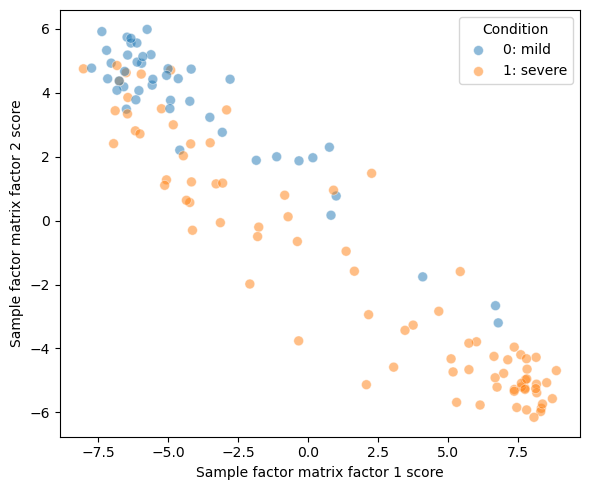

In [174]:
plt.figure(figsize=(6, 5))


g = sns.scatterplot(x=df_sample_r2.iloc[:, 0], y=df_sample_r2.iloc[:, 1], hue=metadata_binary, s=50, alpha=0.5)

# Set axis labels
g.set_xlabel('Sample factor matrix factor 1 score')
g.set_ylabel('Sample factor matrix factor 2 score')

#x_limits = g.get_xlim()
#y_limits = g.get_ylim()

# Calculate the new limits to set equal for both axes
#lim = min(x_limits[0], y_limits[0]), max(x_limits[1], y_limits[1])

# Set the same limits for both axes
#g.set_xlim(lim)
#g.set_ylim(lim)

handles = g.get_legend_handles_labels()[0]
labels = ['0: mild', '1: severe']
g.legend(handles=handles, labels=labels, title='Condition')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'p1-common Omics level factor matrix heatmap')

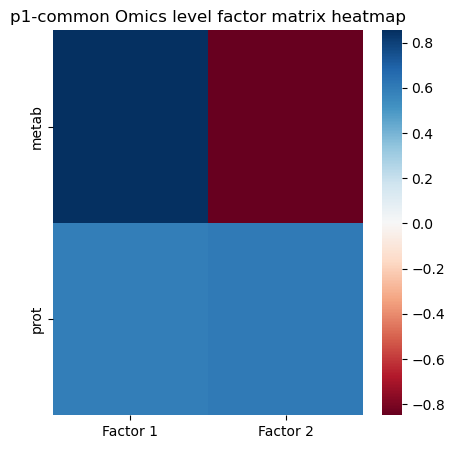

In [277]:
plt.figure(figsize=(5,5))
sns.heatmap(df_omic_r2, cmap='RdBu')
plt.title('p1-common Omics level factor matrix heatmap')

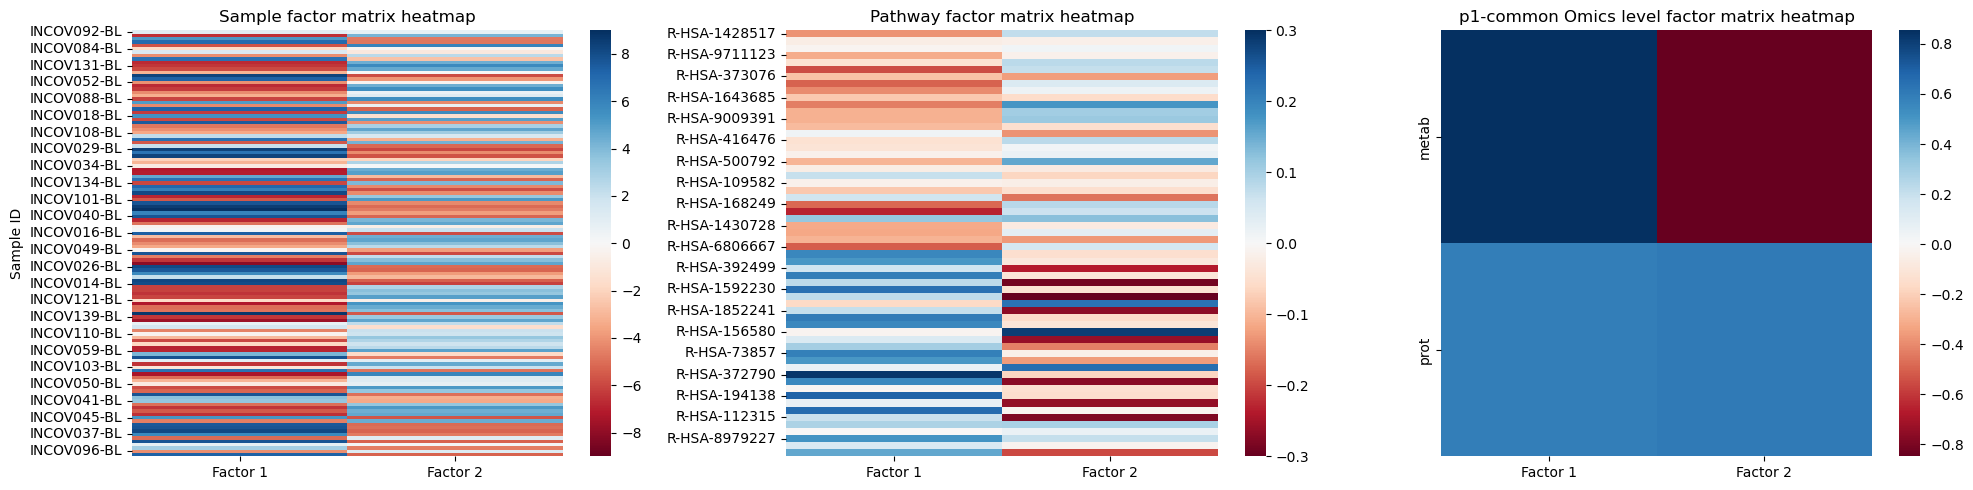

In [276]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.heatmap(df_sample_r2, cmap='RdBu',vmin=-9,vmax=9)
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,3,2)
sns.heatmap(df_pathway_r2, cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.title('Pathway factor matrix heatmap')

plt.subplot(1,3,3)
sns.heatmap(df_omic_r2, cmap='RdBu')
plt.title('p1-common Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

In [308]:
with open('p1_df_pathway_r2.pkl', 'wb') as f:
    pickle.dump(df_pathway_r2, f)

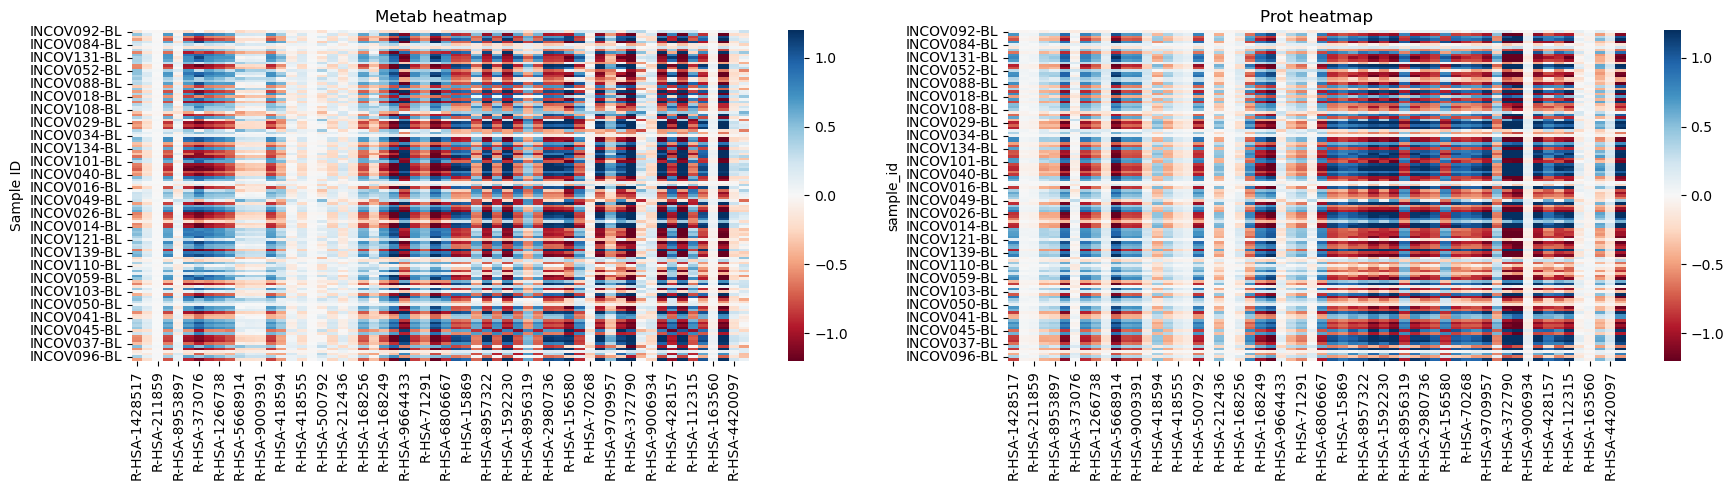

In [85]:
reconstructed_r2 = tl.cp_tensor.cp_to_tensor((weight_r2,cp_tensor_r2))

metab_df_reconstructed_r2 = pd.DataFrame(reconstructed_r2[:,:,0],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)
prot_df_reconstructed_r2 = pd.DataFrame(reconstructed_r2[:,:,1],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(metab_df_reconstructed_r2, cmap='RdBu',vmin=-1.2,vmax=1.2)
plt.title('Metab heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(prot_df_reconstructed_r2, cmap='RdBu',vmin=-1.2,vmax=1.2)
plt.title('Prot heatmap')


plt.tight_layout()
plt.show()

##### reconstructing rank=4 and rank=10

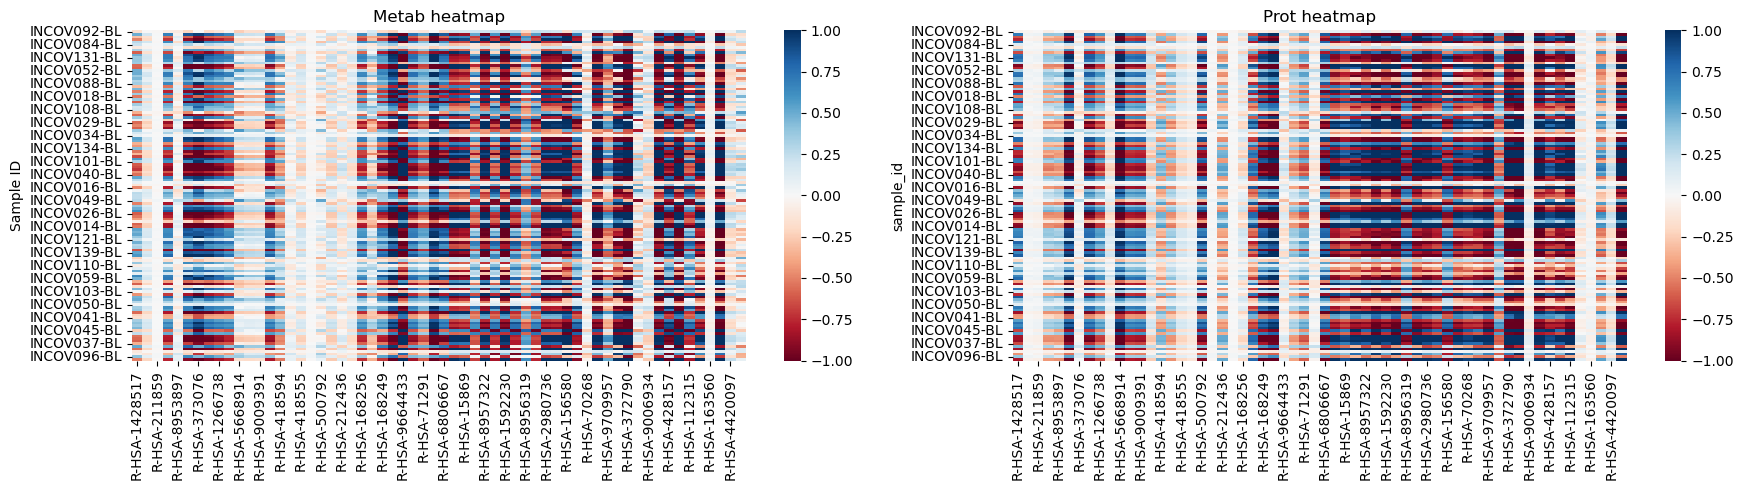

In [86]:
reconstructed_r4 = tl.cp_tensor.cp_to_tensor((weight_r4,cp_tensor_r4))

metab_df_reconstructed_r4 = pd.DataFrame(reconstructed_r2[:,:,0],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)
prot_df_reconstructed_r4 = pd.DataFrame(reconstructed_r2[:,:,1],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(metab_df_reconstructed_r4, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Metab heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(prot_df_reconstructed_r4, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Prot heatmap')


plt.tight_layout()
plt.show()

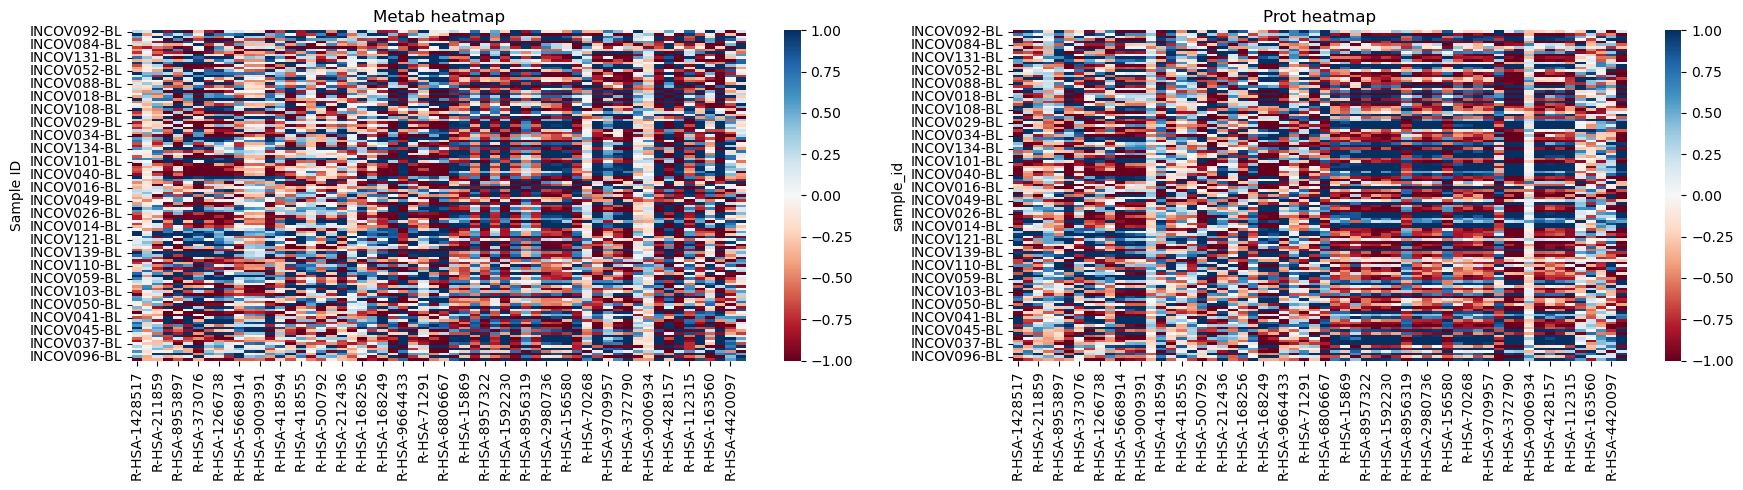

In [87]:
reconstructed_r10 = tl.cp_tensor.cp_to_tensor((weight_r10,cp_tensor_r10))

metab_df_reconstructed_r10 = pd.DataFrame(reconstructed_r10[:,:,0],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)
prot_df_reconstructed_r10 = pd.DataFrame(reconstructed_r10[:,:,1],columns=metab_filtered_kpca.columns,index=metab_filtered_kpca.index)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(metab_df_reconstructed_r10, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Metab heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(prot_df_reconstructed_r10, cmap='RdBu',vmin=-1,vmax=1)
plt.title('Prot heatmap')


plt.tight_layout()
plt.show()

##### Rank=2, pathway cluster map

Text(0.5, 1.0, 'Pathway factor matrix heatmap')

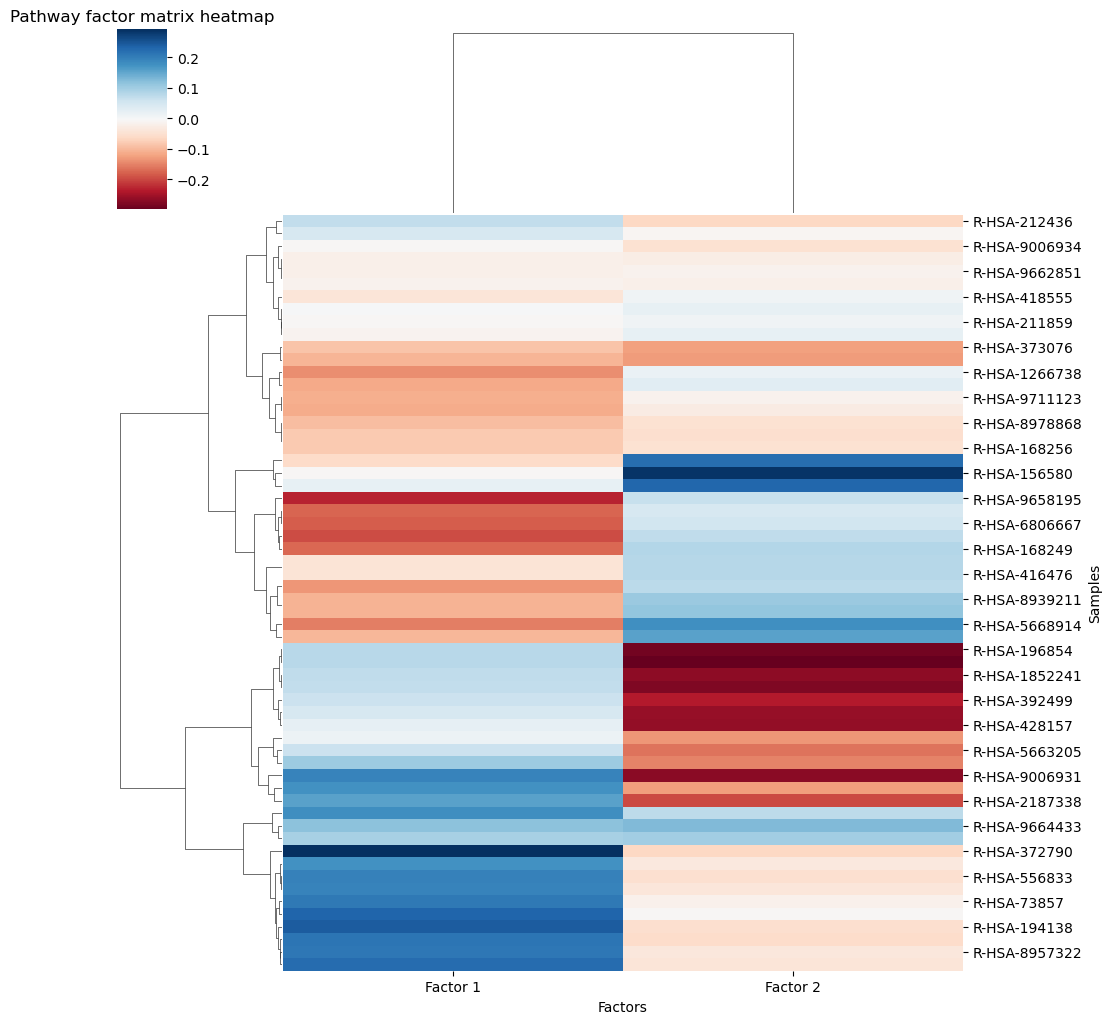

In [307]:
g2=sns.clustermap(df_pathway_r2, 
               cmap='RdBu',method='ward')
g2.ax_heatmap.set_xlabel("Factors")
g2.ax_heatmap.set_ylabel("Samples")
plt.title('Pathway factor matrix heatmap')

In [89]:
pathway_mapping = metab_pathways.set_index(metab_pathways.index)['Pathway_name'].to_dict()
pathway_plt_df = df_pathway[['Factor 1','Factor 2']]
pathway_plt_df['Pathway_name'] = pathway_plt_df.index.map(pathway_mapping)
pathway_plt_df = pathway_plt_df.reset_index()
pathway_plt_df.rename(columns={'index':'Pathway_ID'},inplace=True)

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/2794062724.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Feature selection

In [ ]:
path_facs_bs = bootstrap_feature_select_pr1([metab_filtered_kpca,prot_filtered_kpca])

In [117]:
path_fac1_bs = path_facs_bs[0]
path_fac2_bs = path_facs_bs[1]

In [93]:
path_fac2_bs

R-HSA-1428517  R-HSA-9662851  R-HSA-211859  R-HSA-9711123  R-HSA-8953897  \
0         0.070519      -0.052894     -0.000360      -0.009169       0.085915   
1         0.056459      -0.025732      0.009204      -0.036663       0.095923   
2        -0.095360       0.022171     -0.012746       0.014101      -0.101817   
3         0.046114      -0.015723      0.010268      -0.022526       0.093327   
4         0.079543      -0.039005      0.005545      -0.030285       0.078033   
..             ...            ...           ...            ...            ...   
995       0.069311       0.004693      0.014322      -0.032795       0.101529   
996       0.094250      -0.005484      0.014857      -0.041971       0.069136   
997       0.103916      -0.035602     -0.001135      -0.037702       0.108116   
998       0.056881      -0.028361      0.001719      -0.047183       0.104572   
999      -0.086191      -0.013002     -0.019473       0.004326      -0.048166   

     R-HSA-2262752  R-HSA-373076  R-HSA-73894  R-HSA-1266738  R-HSA-1643685  \
0         0.038371     -0.141404     0.030449       0.003233      -0.089315   
1         0.026721     -0.105614     0.030466       0.024294      -0.056287   
2        -0.038446      0.122919    -0.046095      -0.034869       0.078461   
3         0.093532     -0.120868     0.035373       0.026468      -0.039990   
4         0.045350     -0.121196     0.037151       0.014765      -0.071818   
..             ...           ...          ...            ...            ...   
995       0.062712     -0.118998     0.036436       0.016877      -0.074303   
996       0.039759     -0.127282     0.047675       0.014126      -0.062661   
997       0.089064     -0.144223     0.068513      -0.042281      -0.086852   
998       0.072130     -0.147862     0.028906       0.012469      -0.059631   
999      -0.107529      0.096883    -0.077562      -0.015031       0.007045   

     ...  R-HSA-9006934  R-HSA-194138  R-HSA-428157  R-HSA-381340  \
0    ...      -0.041356     -0.037153     -0.230172      0.008182   
1    ...      -0.052062     -0.057211     -0.236325     -0.012177   
2    ...       0.064133      0.059768      0.217924      0.017396   
3    ...      -0.041864     -0.055988     -0.276784     -0.015211   
4    ...      -0.077879     -0.055735     -0.260206     -0.005277   
..   ...            ...           ...           ...           ...   
995  ...      -0.068841     -0.042913     -0.252596     -0.000896   
996  ...      -0.026884     -0.055661     -0.273666     -0.004907   
997  ...      -0.040221     -0.039695     -0.258849     -0.005879   
998  ...      -0.042204     -0.033138     -0.263760     -0.004258   
999  ...       0.040768      0.056539      0.292931      0.018226   

     R-HSA-112315  R-HSA-382551  R-HSA-163560  R-HSA-8979227  R-HSA-4420097  \
0       -0.264915      0.086101      0.015076       0.073188      -0.007084   
1       -0.273599      0.095242      0.031815       0.068671      -0.023602   
2        0.279707     -0.073600      0.012406      -0.047145       0.009734   
3       -0.278135      0.087724      0.060510       0.052646      -0.013004   
4       -0.277128      0.081742     -0.001925       0.080106      -0.012209   
..            ...           ...           ...            ...            ...   
995     -0.281197      0.099424      0.018101       0.081260      -0.007942   
996     -0.284373      0.119371     -0.011506       0.080724      -0.007505   
997     -0.276155      0.070091      0.006287       0.054189      -0.012653   
998     -0.279708      0.094282      0.026432       0.059483      -0.016734   
999      0.294395     -0.124614     -0.023756      -0.076464       0.010724   

     R-HSA-2187338  
0        -0.171874  
1        -0.182974  
2         0.164684  
3        -0.198173  
4        -0.179119  
..             ...  
995      -0.195543  
996      -0.197441  
997      -0.167893  
998      -0.192282  
999       0.236715  

[1000 rows x 60 columns]

- Bootstrapping

- First method to select significant pathways

In [94]:
import plotly.graph_objects as go

pathway_num = path_fac1_bs.shape[1]

fig = go.Figure()

# Plot mean pathway factor scores for Pathway Factor 1
path_fac1_mean, path_fac1_cis = feature_select_bs_ci(path_fac1_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=path_fac1_mean,
    mode='markers',
    name='Mean Pathway Factor 1 Score ± 95% CI',
    error_y=dict(type='data', array=path_fac1_cis[:, 1]- path_fac1_mean, arrayminus=path_fac1_mean - path_fac1_cis[:, 0]),
    text=path_fac1_bs.columns,
    hoverinfo='text'
))

# Plot mean pathway factor scores for Pathway Factor 2
path_fac2_mean, path_fac2_cis = feature_select_bs_ci(path_fac2_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=path_fac2_mean,
    mode='markers',
    name='Mean Pathway Factor 2 Score ± 95% CI',
    error_y=dict(type='data', array=path_fac2_cis[:, 1] - path_fac2_mean, arrayminus=path_fac2_mean-path_fac2_cis[:, 0]),
    text=path_fac2_bs.columns,
    hoverinfo='text'
))

fig.update_layout(
    title="Pathway Factor Matrix Scores with 95% Confidence Intervals",
    xaxis_title="Pathways",
    yaxis_title="Pathway Factor Score",
    xaxis=dict(tickmode='linear'),  
    showlegend=True,
    width=1000,  
    height=600   
)

fig.show()

- Second method to select significant pathways

In [209]:
p1_pseudoz = combined_pseudoz(path_facs_bs).sort_values(by='Combined',ascending=False)

In [274]:
with open('p1_pseudoz.pkl', 'wb') as f:
    pickle.dump(p1_pseudoz, f)

In [291]:
p1_f2_pseudoz = p1_pseudoz[['Factor 2']].abs().sort_values(by='Factor 2',ascending=False)
p1_f2_pseudoz=p1_f2_pseudoz.rename(columns={'Factor 2':'Combined'})
p1_f2_pseudoz_dict = significant_pseudoz(p1_f2_pseudoz,metab_pathway_dict,95)
p1_f2_pseudoz_dict

3 significant pathways ['R-HSA-6806667', 'R-HSA-1643685', 'R-HSA-168256']


{'R-HSA-6806667': 'Metabolism of fat-soluble vitamins',
 'R-HSA-1643685': 'Disease',
 'R-HSA-168256': 'Immune System'}

In [294]:
p1_f1_pseudoz = p1_pseudoz[['Factor 1']].abs().sort_values(by='Factor 1',ascending=False)
p1_f1_pseudoz=p1_f1_pseudoz.rename(columns={'Factor 1':'Combined'})
p1_f1_pseudoz_dict = significant_pseudoz(p1_f1_pseudoz,metab_pathway_dict,95)
p1_f1_pseudoz_dict

3 significant pathways ['R-HSA-8957322', 'R-HSA-2980736', 'R-HSA-381340']


{'R-HSA-8957322': 'Metabolism of steroids',
 'R-HSA-2980736': 'Peptide hormone metabolism',
 'R-HSA-381340': 'Transcriptional regulation of white adipocyte differentiation'}

In [300]:
p1_sigpath_dict = p1_f1_pseudoz_dict | p1_f2_pseudoz_dict

In [301]:
with open('p1_f1_pseudoz_dict.pkl', 'wb') as f:
    pickle.dump(p1_f1_pseudoz_dict, f)

with open('p1_f2_pseudoz_dict.pkl', 'wb') as f:
    pickle.dump(p1_f2_pseudoz_dict, f)

In [302]:
with open('p1_sigpath_dict.pkl', 'wb') as f:
    pickle.dump(p1_sigpath_dict, f)

In [250]:
mild_ind = []
severe_ind = []
for index in metadata_binary.index:
    if metadata_binary[index] == 0:
        mild_ind.append(index)
    else:
        severe_ind.append(index)

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3651308443.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3651308443.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3651308443.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1500x500 with 0 Axes>

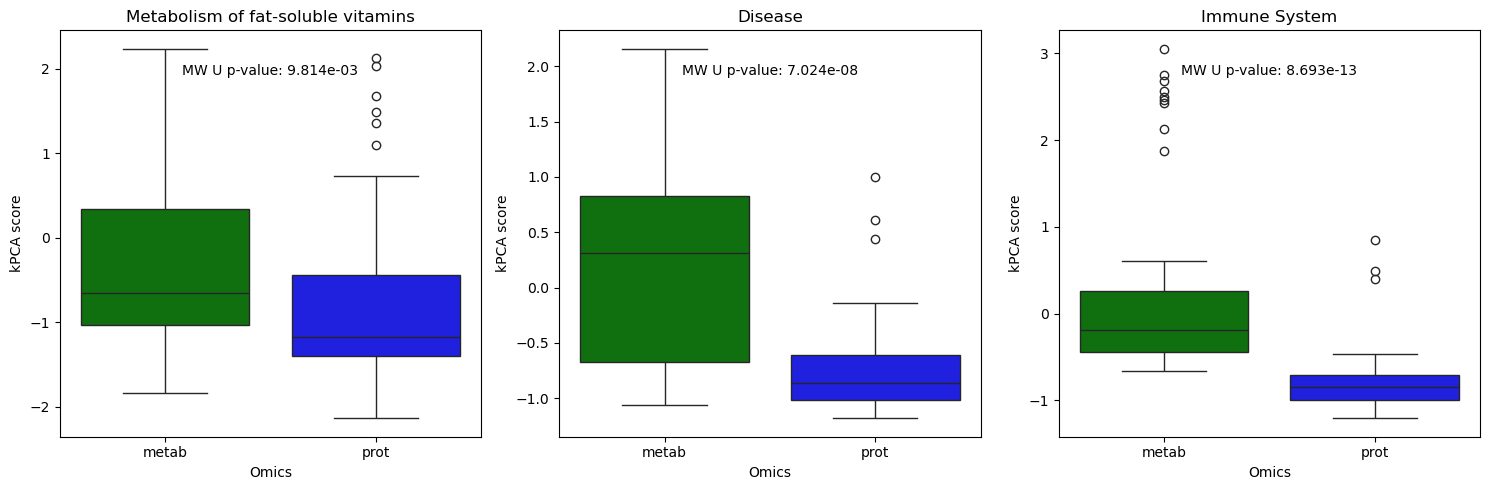

In [313]:
from scipy.stats import mannwhitneyu
plt.figure(figsize=(15, 5))
n_plots = len(p1_f2_pseudoz_dict)
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kPCA score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(p1_f2_pseudoz_dict.items()):
    data = {
        'metab': pred_metab_kpca.loc[mild_ind, pathid],
        'prot': pred_prot_kpca.loc[mild_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kPCA score')
    
    # Create a boxplot and set colors
    sns.boxplot(x='Omics', y='kPCA score', data=df_melted, ax=axes[i], 
                palette={'metab': 'green', 'prot': 'blue'})  

    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/4136116819.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/4136116819.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/4136116819.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1500x500 with 0 Axes>

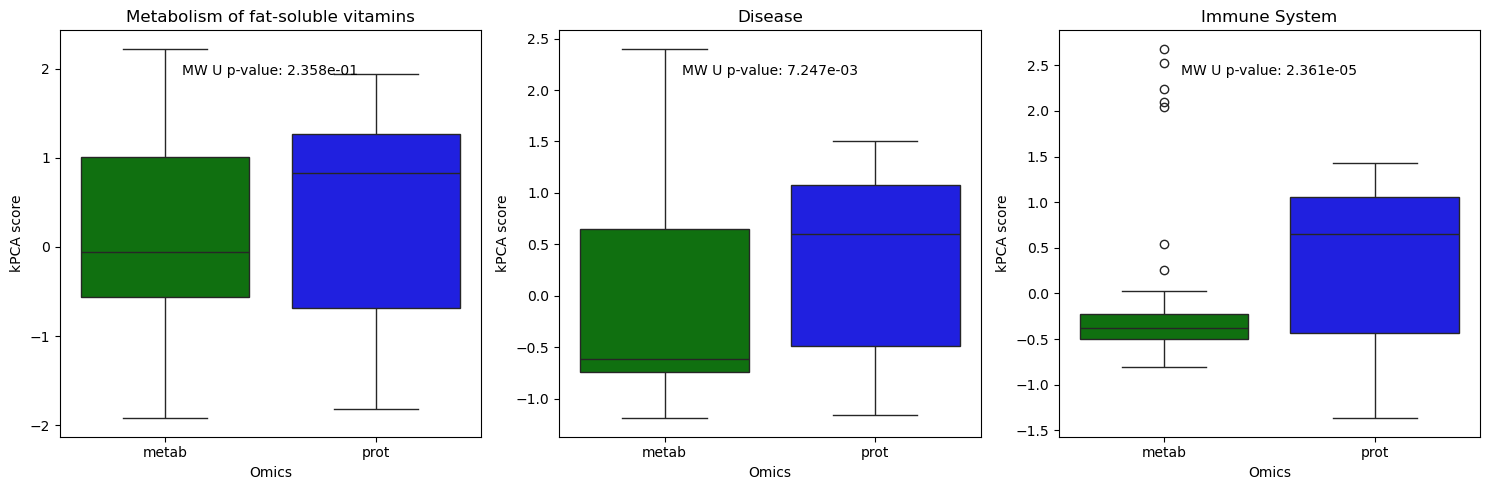

In [314]:
from scipy.stats import mannwhitneyu
plt.figure(figsize=(15, 5))
n_plots = len(p1_f2_pseudoz_dict)
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kPCA score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(p1_f2_pseudoz_dict.items()):
    data = {
        'metab': pred_metab_kpca.loc[severe_ind, pathid],
        'prot': pred_prot_kpca.loc[severe_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kPCA score')
    
    # Create a boxplot and set colors
    sns.boxplot(x='Omics', y='kPCA score', data=df_melted, ax=axes[i], 
                palette={'metab': 'green', 'prot': 'blue'})  

    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3673865149.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3673865149.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/3673865149.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1500x500 with 0 Axes>

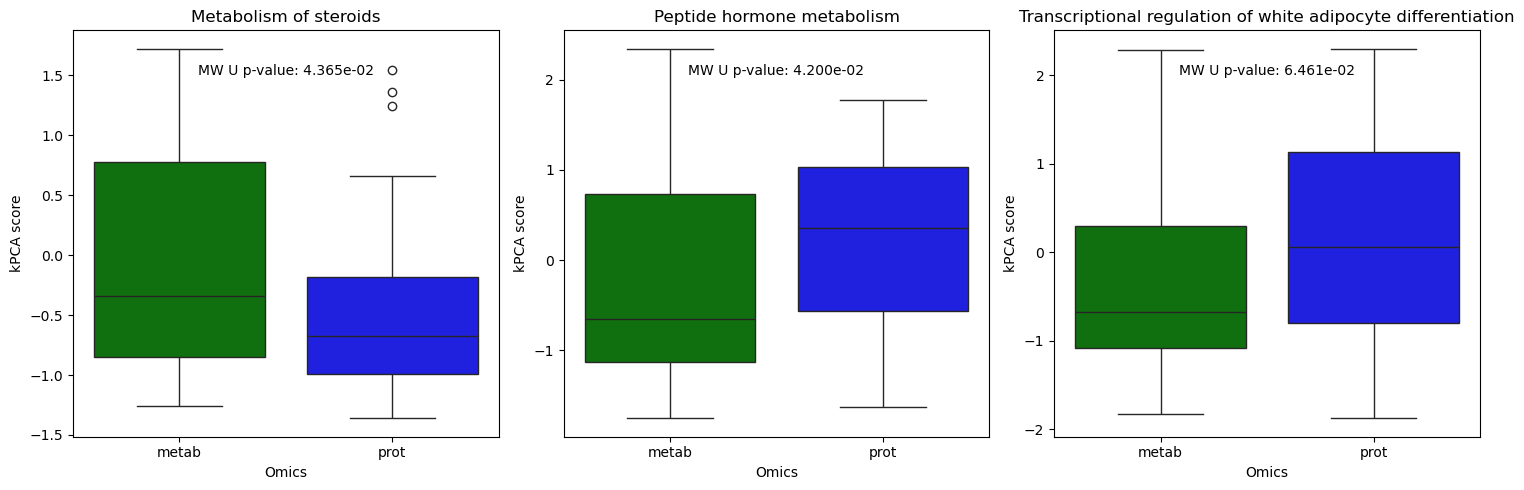

In [316]:
from scipy.stats import mannwhitneyu
plt.figure(figsize=(15, 5))
n_plots = len(p1_f1_pseudoz_dict)
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kPCA score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(p1_f1_pseudoz_dict.items()):
    data = {
        'metab': pred_metab_kpca.loc[mild_ind, pathid],
        'prot': pred_prot_kpca.loc[mild_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kPCA score')
    
    # Create a boxplot and set colors
    sns.boxplot(x='Omics', y='kPCA score', data=df_melted, ax=axes[i], 
                palette={'metab': 'green', 'prot': 'blue'})  

    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/216485552.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/216485552.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_22477/216485552.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1500x500 with 0 Axes>

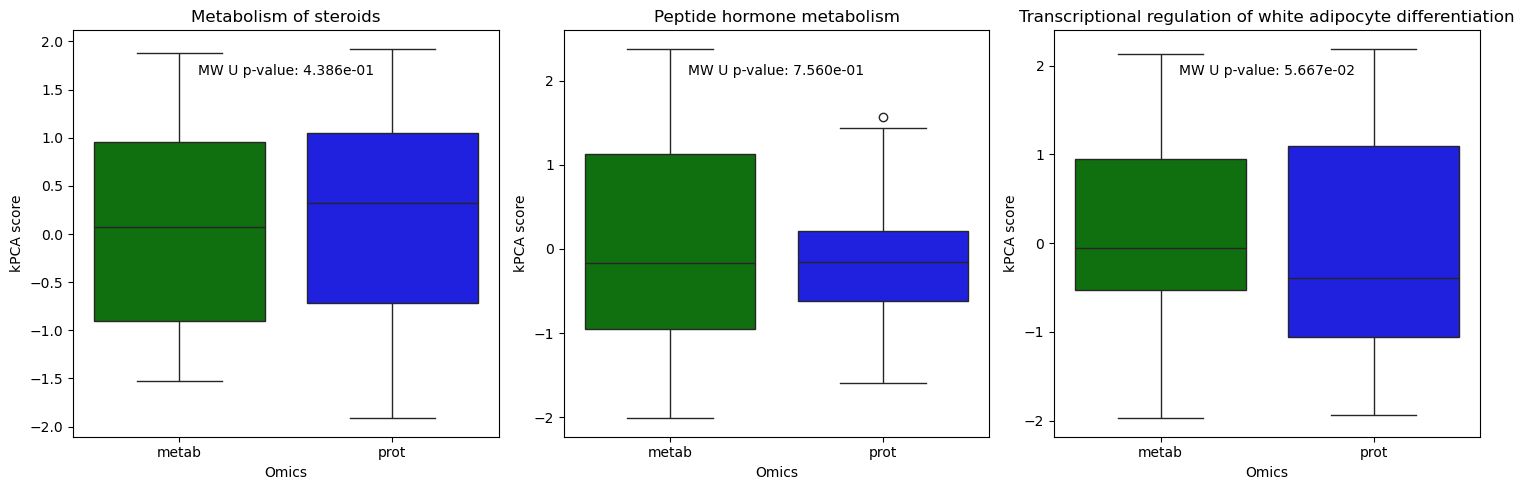

In [317]:
from scipy.stats import mannwhitneyu
plt.figure(figsize=(15, 5))
n_plots = len(p1_f1_pseudoz_dict)
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kPCA score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(p1_f1_pseudoz_dict.items()):
    data = {
        'metab': pred_metab_kpca.loc[severe_ind, pathid],
        'prot': pred_prot_kpca.loc[severe_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kPCA score')
    
    # Create a boxplot and set colors
    sns.boxplot(x='Omics', y='kPCA score', data=df_melted, ax=axes[i], 
                palette={'metab': 'green', 'prot': 'blue'})  

    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [182]:
with open('mw_metab.pkl','rb') as f:
    mw_metab = pickle.load(f)
with open('mw_prot.pkl','rb') as f:
    mw_prot = pickle.load(f)

In [267]:
metab_ps = mw_metab.loc[p1_sigpath_dict.keys()]

In [270]:
prot_ps = mw_prot.loc[p1_sigpath_dict.keys()]

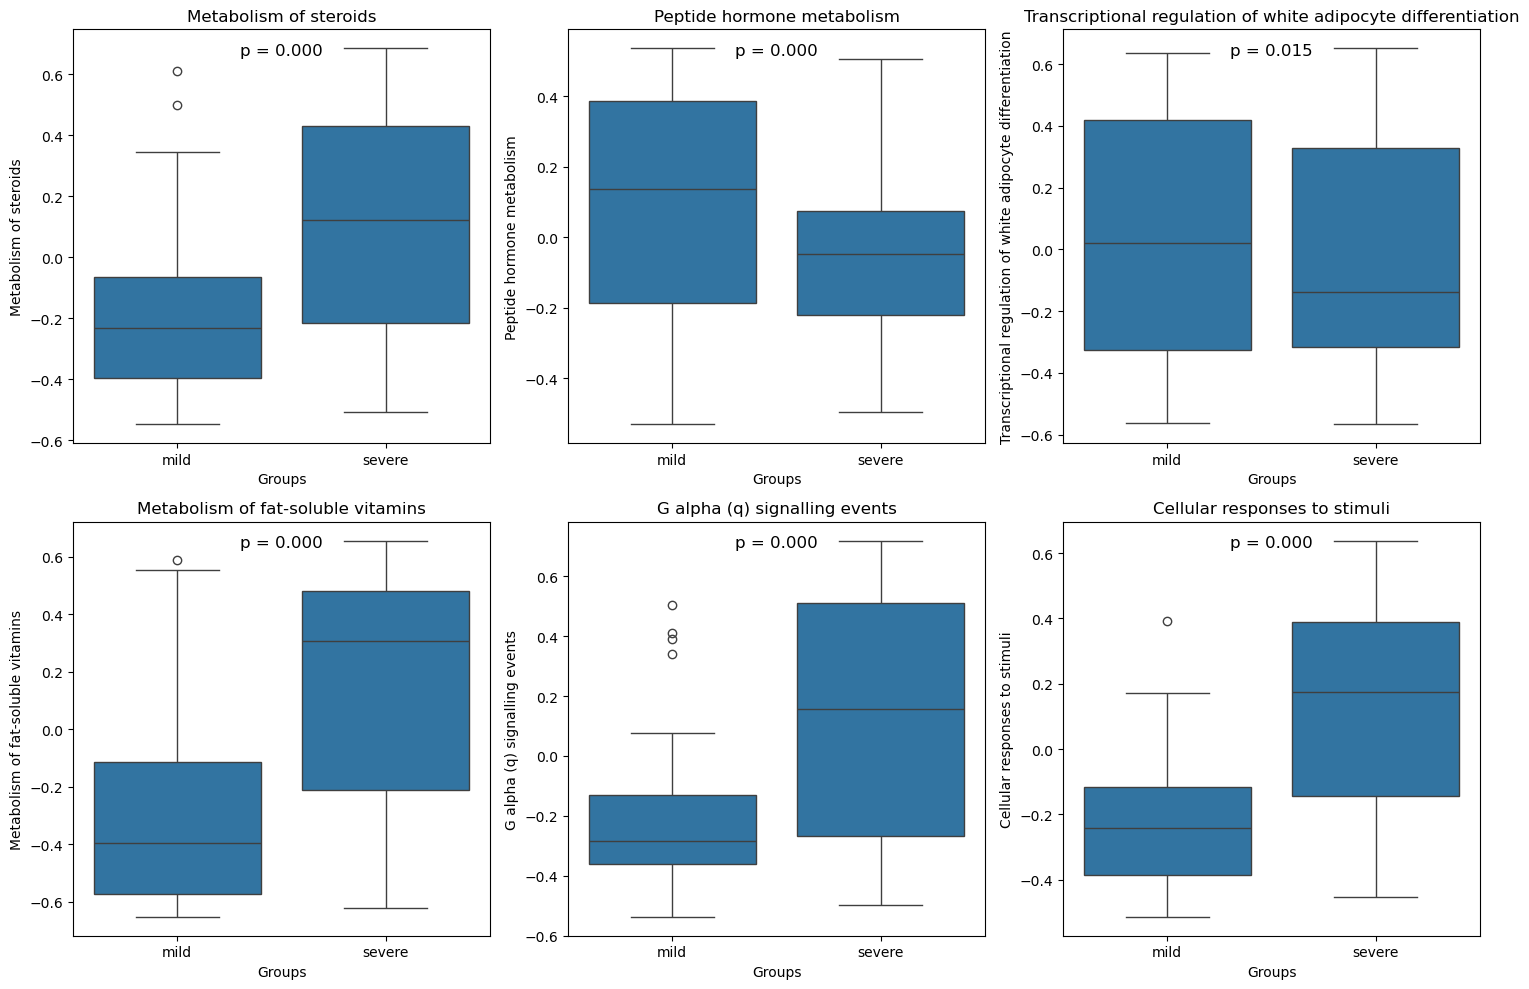

In [271]:
n_plots = len(p1_sigpath_dict)
n_cols = 3  
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

# Assuming metab_ps is a DataFrame that contains the p-values
p_values = prot_ps['p_val']

for i, (pathid, pathname) in enumerate(p1_sigpath_dict.items()):
    data = pd.DataFrame({
        'Group': metadata_binary,
        pathname: prot_filtered_kpca.loc[:, pathid] 
    })
    
    sns.boxplot(x='Group', y=pathname, data=data, ax=axes[i])
    
    # Get the p-value for the current pathid
    p_value = p_values.loc[pathid]
    
    # Show p-value on the plot
    axes[i].text(0.5, 0.95, f'p = {p_value:.3f}', ha='center', va='center', 
                  transform=axes[i].transAxes, fontsize=12, color='black')
    
    axes[i].set_title(f'{pathname}')
    axes[i].set_xlabel('Groups')
    axes[i].set_ylabel(pathname)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['mild', 'severe'])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- third method to select significant pathways: empirical p=values for factor 1 and 2
then combine the p=values using Fischer
use classical p-value threshold. consider multi-correction

In [105]:
p1_harmonic = harmonic_pvalue(path_facs_bs)

In [106]:
p1_harmonic.sort_values(by='Harmonic')

Factor 1  Factor 2  Harmonic
R-HSA-6806667  0.001998  0.288711  0.003969
R-HSA-1643685  0.001998  0.289710  0.003969
R-HSA-9711123  0.001998  0.305694  0.003970
R-HSA-8978868  0.001998  0.305694  0.003970
R-HSA-8979227  0.001998  0.306693  0.003970
R-HSA-71291    0.001998  0.306693  0.003970
R-HSA-71387    0.001998  0.307692  0.003970
R-HSA-556833   0.001998  0.307692  0.003970
R-HSA-15869    0.001998  0.307692  0.003970
R-HSA-8957322  0.001998  0.307692  0.003970
R-HSA-196854   0.001998  0.307692  0.003970
R-HSA-112316   0.001998  0.307692  0.003970
R-HSA-8956319  0.001998  0.307692  0.003970
R-HSA-1852241  0.001998  0.307692  0.003970
R-HSA-2980736  0.001998  0.307692  0.003970
R-HSA-211945   0.001998  0.307692  0.003970
R-HSA-70268    0.001998  0.307692  0.003970
R-HSA-9709957  0.001998  0.307692  0.003970
R-HSA-372790   0.001998  0.307692  0.003970
R-HSA-9006931  0.001998  0.307692  0.003970
R-HSA-194138   0.001998  0.307692  0.003970
R-HSA-112315   0.001998  0.307692  0.003970
R-HSA-382551   0.001998  0.307692  0.003970
R-HSA-9664433  0.001998  0.307692  0.003970
R-HSA-9658195  0.001998  0.307692  0.003970
R-HSA-2187338  0.001998  0.307692  0.003970
R-HSA-5663205  0.001998  0.307692  0.003970
R-HSA-373076   0.001998  0.307692  0.003970
R-HSA-168256   0.001998  0.307692  0.003970
R-HSA-5668914  0.001998  0.307692  0.003970
R-HSA-8939211  0.001998  0.307692  0.003970
R-HSA-9009391  0.001998  0.307692  0.003970
R-HSA-500792   0.001998  0.307692  0.003970
R-HSA-73894    0.001998  0.308691  0.003970
R-HSA-1428517  0.001998  0.308691  0.003970
R-HSA-212436   0.001998  0.312687  0.003971
R-HSA-168249   0.001998  0.314685  0.003971
R-HSA-1592230  0.001998  0.315684  0.003971
R-HSA-2262752  0.001998  0.327672  0.003972
R-HSA-1430728  0.001998  0.331668  0.003972
R-HSA-1266738  0.001998  0.375624  0.003975
R-HSA-73857    0.001998  0.389610  0.003976
R-HSA-381340   0.001998  0.418581  0.003977
R-HSA-416476   0.004995  0.303696  0.009828
R-HSA-392499   0.004995  0.307692  0.009830
R-HSA-8953897  0.009990  0.306693  0.019350
R-HSA-418555   0.016983  0.313686  0.032222
R-HSA-597592   0.017982  0.307692  0.033978
R-HSA-4420097  0.017982  0.320679  0.034054
R-HSA-9662851  0.041958  0.341658  0.074738
R-HSA-428157   0.093906  0.307692  0.143896
R-HSA-74160    0.113886  0.336663  0.170198
R-HSA-162582   0.170829  0.307692  0.219688
R-HSA-109582   0.156843  0.397602  0.224950
R-HSA-418594   0.198801  0.307692  0.241541
R-HSA-388396   0.172827  0.412587  0.243610
R-HSA-9006934  0.291708  0.303696  0.297582
R-HSA-156580   0.298701  0.307692  0.303130
R-HSA-211859   0.337662  0.365634  0.351092
R-HSA-163560   0.456543  0.465534  0.460995

In [129]:
parafac1_sigpath = list(p1_harmonic.index[p1_harmonic['Harmonic'] < 0.01])

In [130]:
len(parafac1_sigpath)

45

In [109]:
with open('parafac1_sigpath.pkl', 'wb') as f:
    pickle.dump(parafac1_sigpath, f)

#### Investigating significant pathways

- for significant pathways, extract the lists of analytes that contribute to the pathway kpca scoring, and consult analyte data in metab/prot

In [110]:
metab_pathway_compounds = sspa.utils.pathwaydf_to_dict(metab_pathways)

In [111]:
prot_pathway_compounds = sspa.utils.pathwaydf_to_dict(prot_pathways)

In [112]:
TNF_pathways = []
for pathway, compounds in prot_pathway_compounds.items():
    if pathway in prot_filtered_kpca.columns and 'TNF' in compounds:
        TNF_pathways.append(pathway)

In [113]:
TNF_pathways

['R-HSA-1266738', 'R-HSA-168256', 'R-HSA-162582', 'R-HSA-381340']

In [114]:
def sigPathway_compound_df(significant_pathways, omics_mat, dict_pathway_compounds):

    sigPathway_compound_dict = {}
    for pathway, compounds in dict_pathway_compounds.items():
        if pathway in significant_pathways.keys():
            sigPathway_compound_dict[pathway] = omics_mat.drop(omics_mat.columns.difference(compounds),axis=1)
        else:
            continue

    compound_list = []
    for pathway,compound_dfs in sigPathway_compound_dict.items():
        for compound in compound_dfs.columns:
            if compound not in compound_list:
                compound_list.append(compound)
            else:
                continue
    
    freq_summary_df = pd.DataFrame(0, index=significant_pathways.keys(), columns=compound_list)

    for pathway, compound_dfs in sigPathway_compound_dict.items():
        for compound in compound_dfs.columns:
            freq_summary_df.at[pathway,compound] = 1
    
    sets_of_compound = []
    for pathway,compound_dfs in sigPathway_compound_dict.items():
        compound_set = frozenset(compound_dfs.columns)
        if compound_set not in sets_of_compound:
            sets_of_compound.append(compound_set)
    
    sets_mapping = {compound_set: index for index, compound_set in enumerate(sets_of_compound)}
    freq_summary_df['Compound set index'] = freq_summary_df.index.map(lambda pathway: sets_mapping.get(frozenset(sigPathway_compound_dict[pathway].columns), -1))
    
    return sigPathway_compound_dict, freq_summary_df


In [115]:
metab_sig, metab_freq_summary = sigPathway_compound_df(fac1_zscore_path,metab,metab_pathway_compounds)

NameError: name 'fac1_zscore_path' is not defined

In [ ]:
metab_freq_summary

17351  15756  16990  16393  16238  16349  30805  28716  28875  \
R-HSA-9658195      0      0      0      0      0      0      0      0      0   
R-HSA-1592230      1      1      1      0      0      0      0      0      0   
R-HSA-2980736      0      1      0      0      0      0      1      1      1   
R-HSA-372790       0      1      0      0      0      0      1      1      1   
R-HSA-194138       0      0      0      1      1      1      0      0      0   
R-HSA-381340       1      1      1      0      0      0      0      0      0   

               16359  ...  28834  15729  422  28790  16335  27732  17754  \
R-HSA-9658195      1  ...      1      0    0      1      1      0      0   
R-HSA-1592230      0  ...      0      0    0      0      0      0      0   
R-HSA-2980736      0  ...      0      0    0      0      0      0      0   
R-HSA-372790       1  ...      1      1    1      1      1      1      1   
R-HSA-194138       0  ...      0      0    0      0      0      0      0   
R-HSA-381340       0  ...      0      0    0      0      0      0      0   

               2700  37098  Compound set index  
R-HSA-9658195     0      0                   4  
R-HSA-1592230     0      0                   0  
R-HSA-2980736     0      0                   2  
R-HSA-372790      1      1                   3  
R-HSA-194138      0      0                   1  
R-HSA-381340      0      0                   0  

[6 rows x 21 columns]

In [ ]:
prot_sig, _ = sigPathway_compound_df(fac1_zscore_path,prot,prot_pathway_compounds)
prot_sig['R-HSA-381340']

LPL       LEP     TGFB1       TNF     PLIN1
sample_id                                                     
INCOV092-BL  11.530477  8.328695  8.221268  1.405134  3.761374
INCOV107-BL   9.035225  5.899490  8.523417  0.663733  2.744378
INCOV020-BL   8.942615  3.133069  8.457999  2.563451  2.566158
INCOV035-BL   9.767932  5.421902  8.294638  2.772716  2.175135
INCOV122-BL  10.051686  6.416338  8.813876  0.401473  2.797030
...                ...       ...       ...       ...       ...
INCOV030-BL  10.241428  6.080935  7.857729  1.544073  3.426432
INCOV102-BL  11.773387  6.661378  7.825420  0.903920  4.112322
INCOV027-BL  10.028516  8.185266  8.024598  1.208167  3.439394
INCOV096-BL  10.147911  8.361307  9.415916  2.336076  3.438160
INCOV031-BL   8.225115  3.507037  8.286553  1.764578  2.522556

[127 rows x 5 columns]

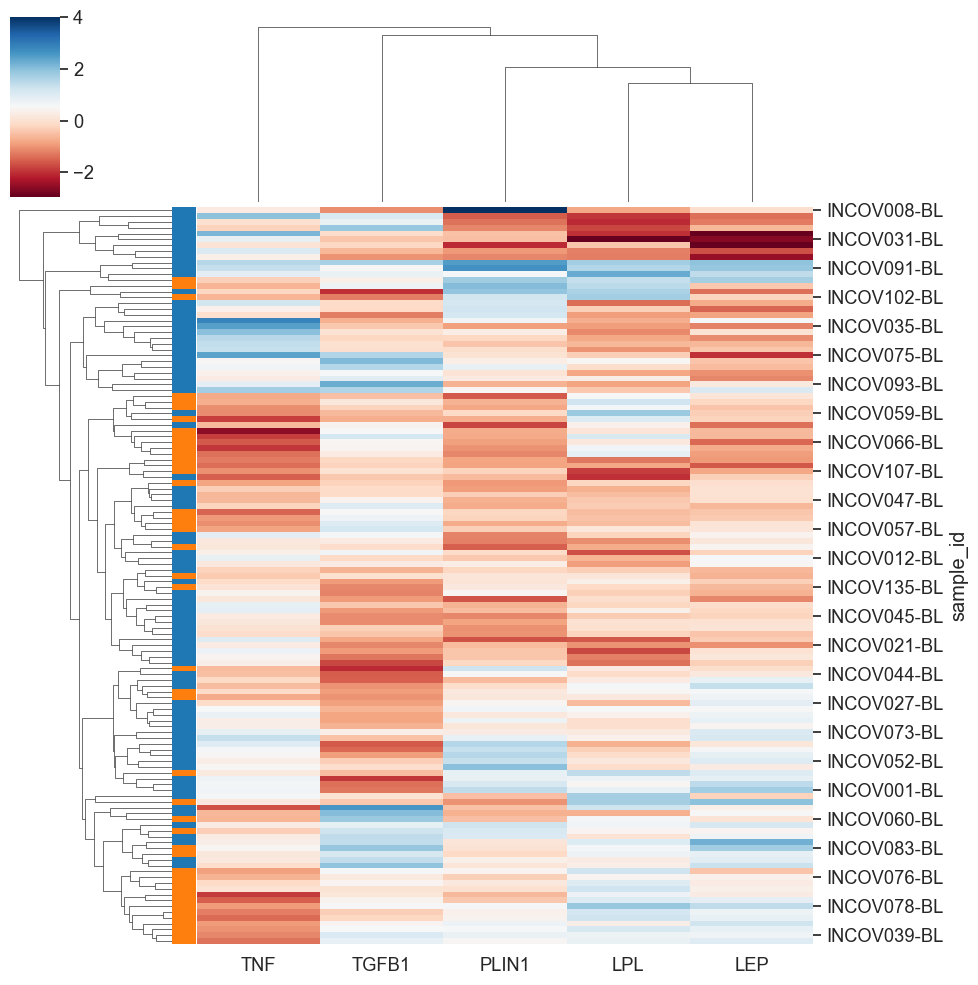

In [ ]:
sns.clustermap(pd.DataFrame(scale(prot_sig['R-HSA-381340']),index = prot_sig['R-HSA-381340'].index,
                            columns= prot_sig['R-HSA-381340'].columns), 
               row_colors=["tab:blue" if i == 1 else "tab:orange" for i in metadata_binary],
               cmap='RdBu')

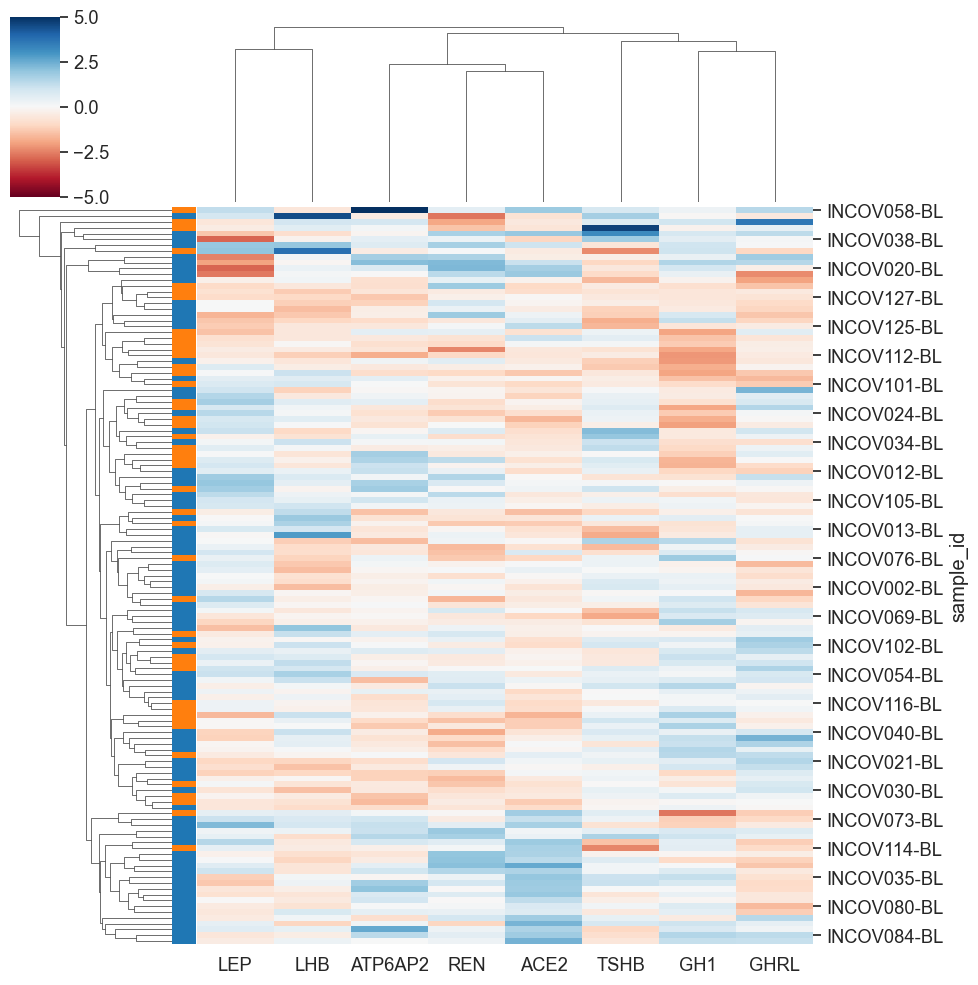

In [ ]:
sns.clustermap(pd.DataFrame(scale(prot_sig['R-HSA-2980736']),index = prot_sig['R-HSA-2980736'].index,
                            columns= prot_sig['R-HSA-2980736'].columns), vmin=-5,vmax=5,
               row_colors=["tab:blue" if i == 1 else "tab:orange" for i in metadata_binary],
               cmap='RdBu')

In [ ]:
metab_sig

{'R-HSA-1592230':                 17351     15756     16990
 sample_id                                
 INCOV092-BL  1.134515  1.396143  0.907167
 INCOV107-BL  0.954264  1.315114  1.341479
 INCOV020-BL  1.909507  1.021051  1.028291
 INCOV035-BL  1.531860  0.971971  0.617543
 INCOV122-BL  0.555152  0.709502  1.025649
 ...               ...       ...       ...
 INCOV030-BL  0.736876  0.811780  0.715951
 INCOV102-BL  1.292311  0.959057  0.742577
 INCOV027-BL  3.835328  3.200510  0.646773
 INCOV096-BL  0.879823  1.139763  0.176955
 INCOV031-BL  0.879823  0.590502  0.475093
 
 [127 rows x 3 columns],
 'R-HSA-194138':                 16393     16238     16349
 sample_id                                
 INCOV092-BL  1.641559  1.835436  0.755653
 INCOV107-BL  2.548243  1.370900  0.858800
 INCOV020-BL  1.063418  0.768709  0.755653
 INCOV035-BL  1.163340  1.191707  0.971186
 INCOV122-BL  2.599335  1.291430  0.840952
 ...               ...       ...       ...
 INCOV030-BL  1.114937  0.462399  0.4

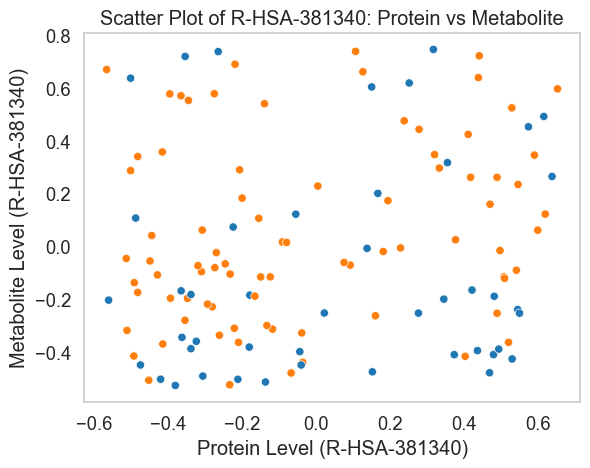

In [ ]:
plot_data = pd.DataFrame({
    'Protein': prot_filtered_kpca['R-HSA-381340'],
    'Metabolite': metab_filtered_kpca['R-HSA-381340']})

# Create the scatter plot

sns.scatterplot(data=plot_data, x='Protein', y='Metabolite', hue=metadata_binary, legend=False)

# Adding titles and labels
plt.title('Scatter Plot of R-HSA-381340: Protein vs Metabolite')
plt.xlabel('Protein Level (R-HSA-381340)')
plt.ylabel('Metabolite Level (R-HSA-381340)')

# Show the plot
plt.grid()
plt.show()

In [ ]:
diabetic_sample_id = processed_sample_data[(processed_sample_data['Diabetes']== 'T2DM') | (processed_sample_data['Diabetes']=='T1DM')].index

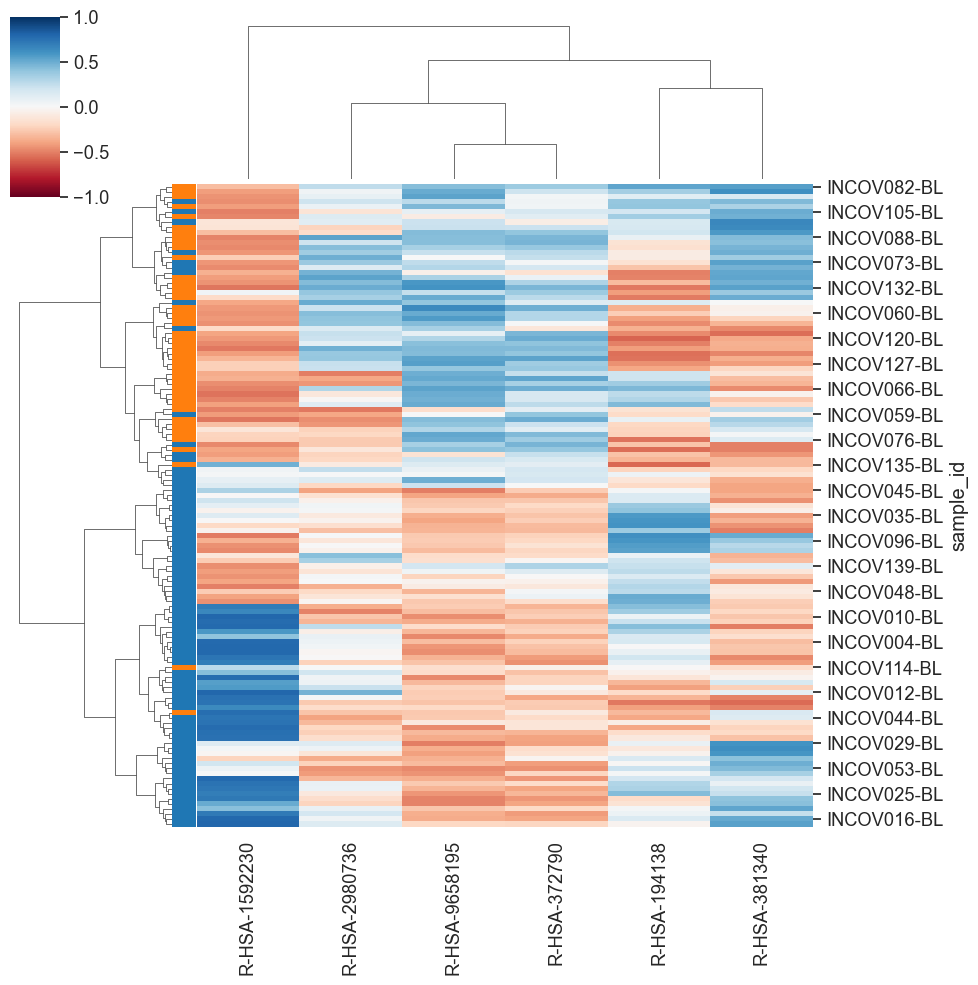

In [ ]:
sns.clustermap(prot_filtered_kpca.loc[:,fac1_zscore_path.keys()],
               cmap='RdBu',
               vmin=-1,vmax=1,
               row_colors=["tab:blue" if i == 1 else "tab:orange" for i in metadata_binary],
               method='ward')

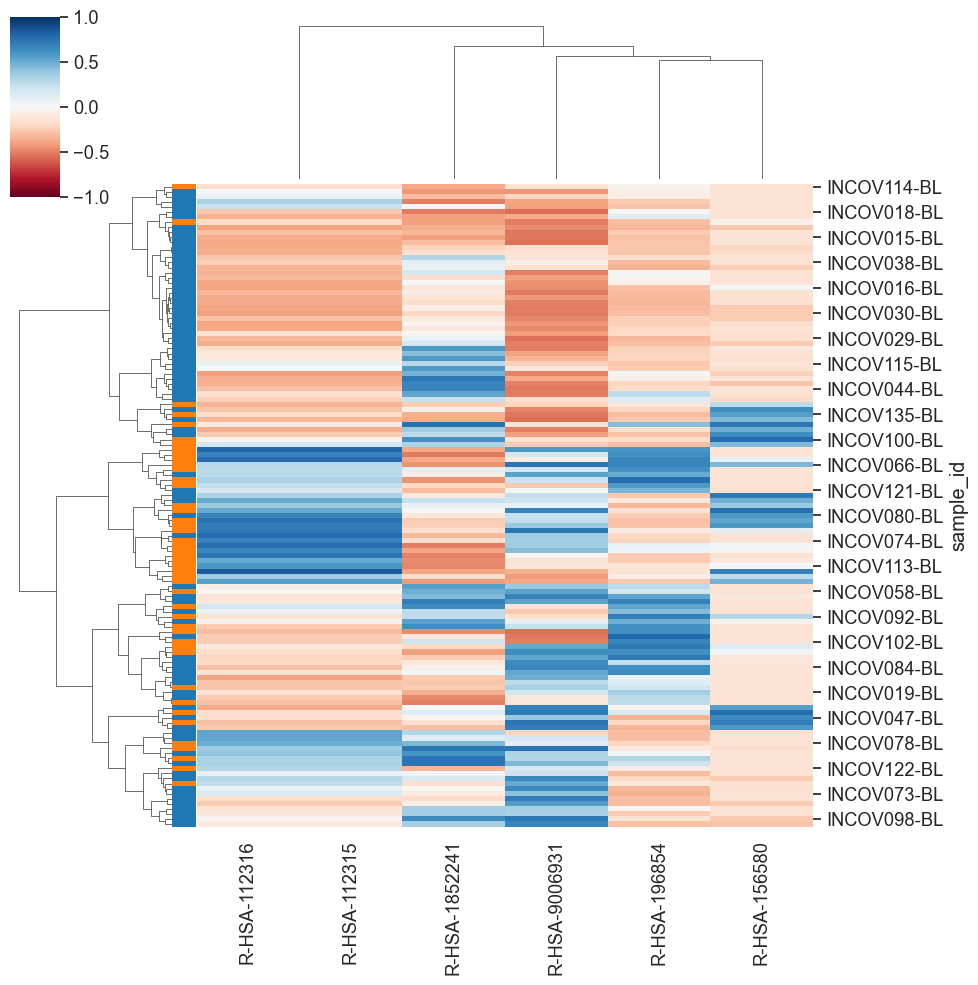

In [ ]:
sns.clustermap(metab_filtered_kpca.loc[:,fac2_zscore_path.keys()],
               cmap='RdBu',
               vmin=-1,vmax=1,
               row_colors=["tab:blue" if i == 1 else "tab:orange" for i in metadata_binary],
               method='ward')

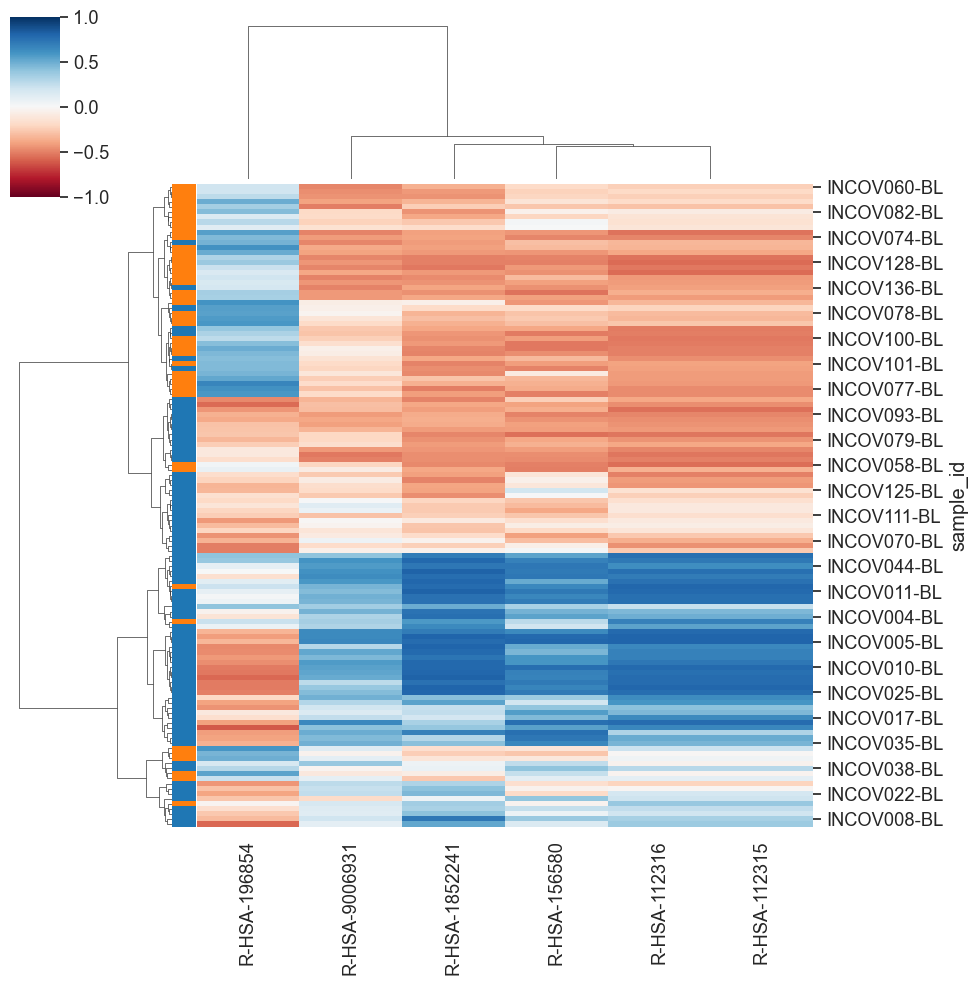

In [ ]:
sns.clustermap(prot_filtered_kpca.loc[:,fac2_zscore_path.keys()],
               cmap='RdBu',
               vmin=-1,vmax=1,
               method='ward',
               row_colors=["tab:blue" if i == 1 else "tab:orange" for i in metadata_binary])